In [1]:
#Import Necessary Packages

import xarray as xr
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import metpy 
import metpy.calc as mpcalc 
from metpy.plots import SkewT
from metpy.units import units
from IPython.display import HTML, display 
import imageio
from tqdm import tqdm
from itertools import product
import random
import matplotlib.gridspec as gridspec
import wrf

Cannot import USCOUNTIES and USSTATES without Cartopy installed.


In [2]:
#Create Path For Data Collection 
computations_path =  '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/'
storm16_data_path =  '/storage/work/bsh5393/storm16/'

#Create A List of File Names For Each Storm
computations_files = os.listdir(computations_path)
storm16_files = os.listdir(storm16_data_path)

#Remove Unneccessary Files From Each List
storm16_files.remove('README-TIMELEVELS')
storm16_files.remove('namelist.input')
storm16_files.remove('runstorm16.pbs.o44255112')
storm16_files.remove('cm1out_stats.nc')
computations_files.remove('.ipynb_checkpoints')

In [3]:
computations_path+computations_files[1]


'/storage/work/bsh5393/Variability Study/Data/computations25kmx25km(t=0hrs)-REVISED4MS.nc'

In [4]:
#Read In Data

storm16_data = xr.open_dataset(storm16_data_path+storm16_files[0])
computations_data = xr.open_dataset(computations_path + computations_files[1])

#Start Creating Global Variables for All Storms

#Dataset Sizes
ni = storm16_data['ni']
nj = storm16_data['nj']
nk = storm16_data['nk']

#Datapoint Locations
x_data = storm16_data['xh']*units.kilometer
y_data = storm16_data['yh']*units.kilometer
z_data = storm16_data['z']*units.kilometer

#Grid Locations (n+1)
x_grid = storm16_data['xf']*units.kilometer
y_grid = storm16_data['yf']*units.kilometer
z_grid = storm16_data['zf']*units.kilometer

# Bounds of Computation 
midpoint = round(len(x_data)/2)-1 #Roughly the Middle of the Domain (Not Exact Because Even Number of Points)
slope = (x_data[2]-x_data[1]).values #Distance Between Each Point
num_points = round(25/2/slope)
upper_bound = midpoint + num_points + 1
lower_bound = midpoint - num_points 
horiz_length = upper_bound-lower_bound

# Grab additional data within the box bounds for STP Calculation (Need to Calculate BWD, LCL - bring in wind and temperature data)
P = storm16_data['prs'].loc[:,:,lower_bound:upper_bound, lower_bound:upper_bound][0]/100
qv = storm16_data['qv'].loc[:,:,lower_bound:upper_bound, lower_bound:upper_bound][0]
u = storm16_data['uinterp'].loc[:,:,lower_bound:upper_bound, lower_bound:upper_bound][0]
v = storm16_data['vinterp'].loc[:,:,lower_bound:upper_bound, lower_bound:upper_bound][0]
w = storm16_data['winterp'].loc[:,:,lower_bound:upper_bound, lower_bound:upper_bound][0]
Th = storm16_data['th'].loc[:,:,lower_bound:upper_bound, lower_bound:upper_bound][0]
T = mpcalc.temperature_from_potential_temperature(P*units.hPa, Th*units.kelvin)
Td = wrf.td(P, qv) + 273.15

# Height indices for ~ 0, 6 km
z_6km = (np.abs(z_data.values -6)).argmin()
z_0km = 0

# Inspect
computations_data.head()

<xarray.Dataset>
Dimensions:      (dim_0: 5, dim_1: 5, ni: 5, nj: 5, nk: 5)
Coordinates:
    x-direction  (ni) int64 ...
    y-direction  (nj) int64 ...
    z-direction  (nk) int64 ...
Dimensions without coordinates: dim_0, dim_1, ni, nj, nk
Data variables:
    CAPE         (nk, nj, ni) float32 ...
    CIN          (nk, nj, ni) float32 ...
    SRH1km       (dim_0, dim_1) float32 ...
    SRH3km       (dim_0, dim_1) float32 ...
    w_7.5        (nj, ni) float32 ...
    w_500        (nj, ni) float32 ...
    STP          (nj, ni) float32 ...
    BWD          (nj, ni) float32 ...

In [5]:
# STP Calculations 


# Step 1: CAPE and CIN (Already computed within the computations_data xarray)

# Step 2: Storm Relative Helicity (Already computed within the computations_data xarray)

# Step 3: Bulk Wind Difference (0 - 6 km)
u_sfc = u[z_0km]
v_sfc = v[z_0km]
u_6km = u[z_6km]
v_6km = v[z_6km]

BWD_u = u_6km - u_sfc
BWD_v = v_6km - v_sfc
BWD = (BWD_u**2 + BWD_v**2)**(1/2)

# Step 4: Compute LCLs (Find a few values across the whole domain and then take the average and call it a constant value)
LCLs = np.zeros(10) # storage 
for x in tqdm(range(10)):
    # Select Random Location on grid 
    i = random.randint(0, P.shape[1])
    j = random.randint(0, P.shape[1])
    
    # Calculate LCL using metpy (units of pressure)
    LCL_prs = mpcalc.lcl(P.isel(nk=0, nj = j, ni = i)*units.hPa, T.isel(nk=0, nj = j, ni = i),
                         Td.isel(nk=0, nj = j, ni = i)*units.kelvin)[0]
    # Calculate LCL in height (km)
    LCL_m = mpcalc.pressure_to_height_std(LCL_prs).m
    
    # Save value 
    LCLs[x] = LCL_m
# Take average (m)
SB_LCL = LCLs.mean()*1000

# Step 5: Compute STP
STP = (computations_data['CAPE'][0].values/1500)*((2000-SB_LCL)/1000)*(computations_data['SRH1km'].values/150)*((200+computations_data['CIN'][0].values)/150)*(BWD/20)
    

100%|██████████| 10/10 [00:00<00:00, 123.46it/s]


Text(0.76, 0.47, 'STP')

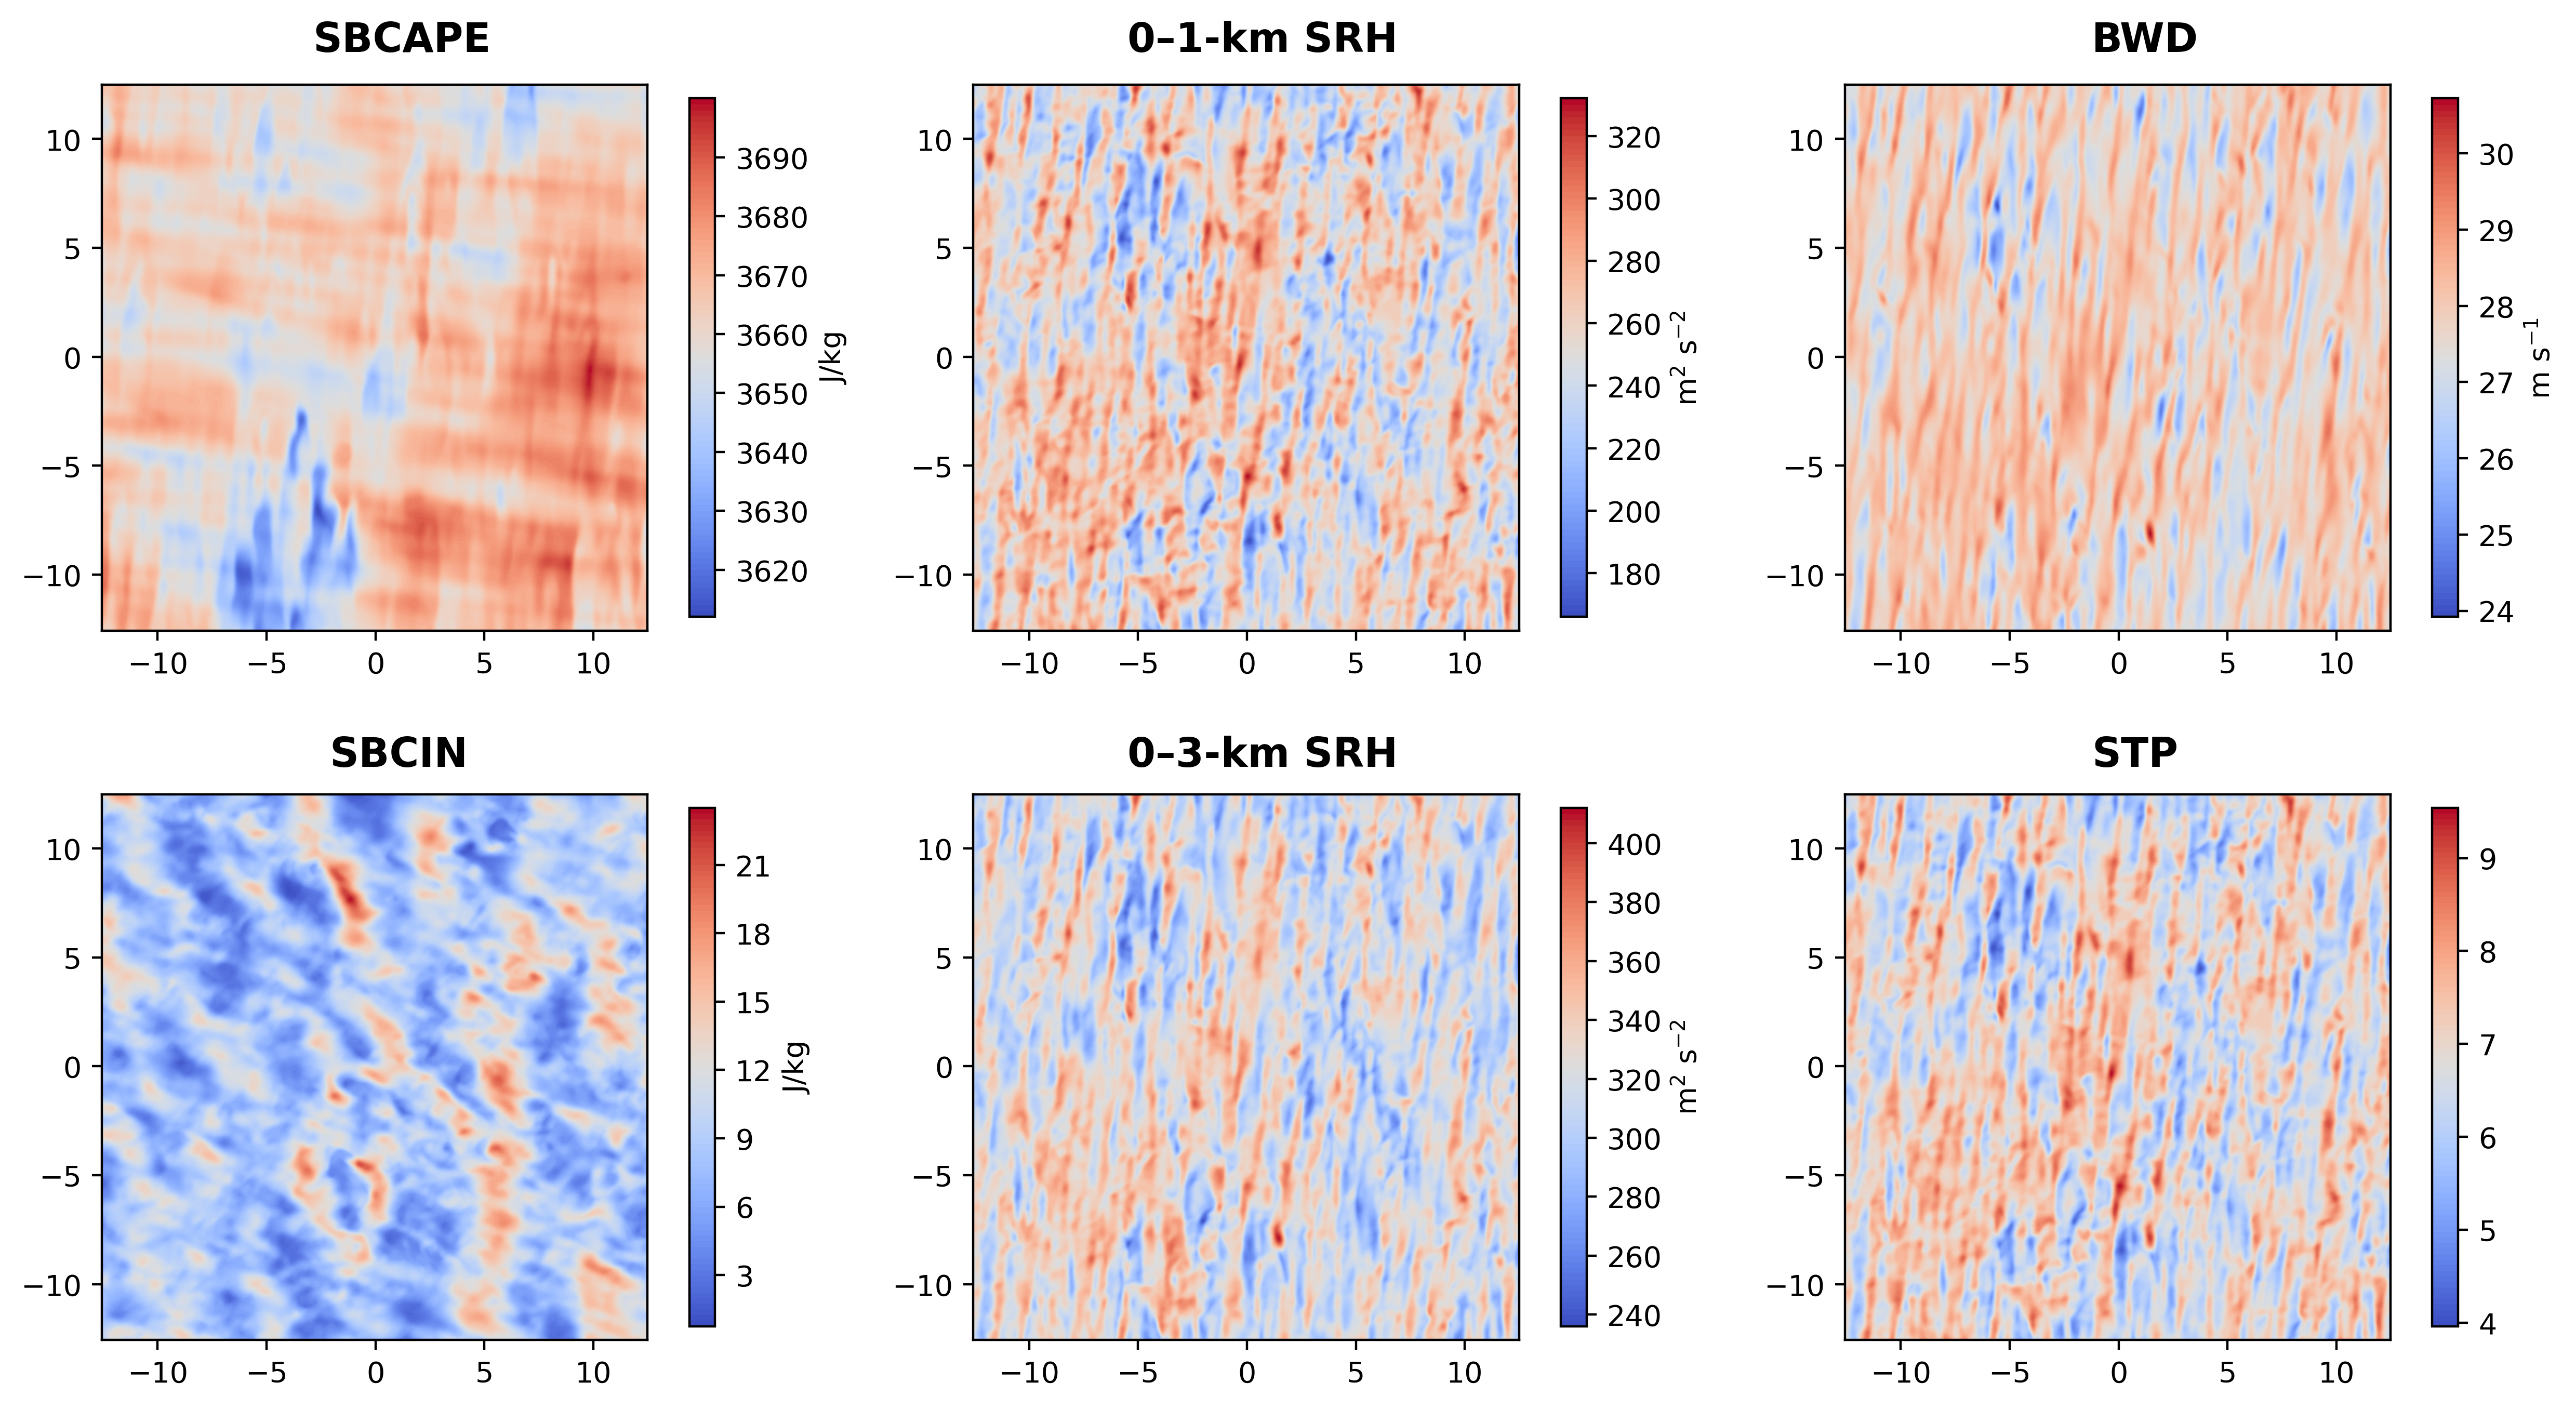

In [17]:
# Try To Create a Figure with all 5 fields (For MS Defense)

fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (16,8), dpi = 400)
plt.subplots_adjust(wspace=0.045, hspace=0.3)

# Axis 1: CAPE
ax1 = axs[0,0].contourf(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']],
                  computations_data['CAPE'][0],cmap = 'coolwarm', levels = 100)
fig.colorbar(ax1, ax=axs[0, 0], orientation='vertical', shrink = 0.95, ticks = np.arange(3600, 3700, 10), label= 'J/kg')
axs[0,0].set_aspect('equal')

# Axis 2: CIN 
ax2 = axs[1, 0].contourf(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']],
                  computations_data['CIN'][0],cmap = 'coolwarm', levels = 100)
fig.colorbar(ax2, ax=axs[1, 0], orientation='vertical', shrink = 0.95, ticks =np.arange(0, 25, 3), label = 'J/kg')
axs[1, 0].set_aspect('equal')

# Axis 3: SRH1km
ax3 = axs[0, 1].contourf(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']],
                  computations_data['SRH1km'],cmap = 'coolwarm', levels = 100)
fig.colorbar(ax3, ax=axs[0, 1], orientation='vertical', shrink = 0.95, ticks = np.arange(160, 340, 20), label = 'm$^2$ s$^{-2}$')
axs[0,1].set_aspect('equal')

# Axis 4: SRH3km
ax4 = axs[1, 1].contourf(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']],
                  computations_data['SRH3km'],cmap = 'coolwarm', levels = 100)
fig.colorbar(ax4, ax=axs[1, 1], orientation='vertical', shrink = 0.95, ticks = np.arange(220, 420, 20), label = 'm$^2$ s$^{-2}$')
axs[1,1].set_aspect('equal')
# Axis 5: BWD
ax5 = axs[0, 2].contourf(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']],
                  computations_data['BWD'],cmap = 'coolwarm', levels = 100)
fig.colorbar(ax5, ax=axs[0, 2], orientation='vertical', shrink = 0.95, ticks = np.arange(23, 31, 1), label = 'm s$^{-1}$')
axs[0, 2].set_aspect('equal')
# Axis 6: STP
ax6 = axs[1, 2].contourf(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']],
                  computations_data['STP'],cmap = 'coolwarm', levels = 100)
fig.colorbar(ax6, ax=axs[1, 2], orientation='vertical', shrink = 0.95, ticks =np.arange(3,10, 1))
axs[1,2].set_aspect('equal')

# Add text labels to each top right corner
fig.text(0.225, 0.9, 'SBCAPE', fontsize = 14, weight = 'demibold')
fig.text(0.47, 0.9, '0–1-km SRH', fontsize = 14, weight = 'demibold')
fig.text(0.76, 0.9, 'BWD', fontsize = 14, weight = 'demibold')
fig.text(0.23, 0.47, 'SBCIN', fontsize = 14, weight = 'demibold')
fig.text(0.47, 0.47, '0–3-km SRH', fontsize = 14, weight = 'demibold')
fig.text(0.76, 0.47, 'STP', fontsize = 14, weight = 'demibold')



Text(0.66, 0.48, 'f)')

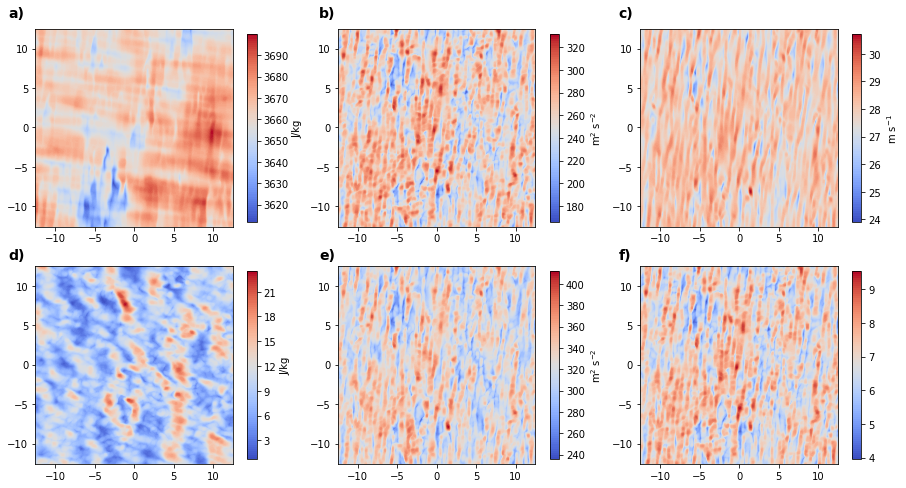

In [35]:
# Try To Create a Figure with all 5 fields

fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (16,8))
plt.subplots_adjust(wspace=0.05, hspace=0.2)

# Axis 1: CAPE
ax1 = axs[0,0].contourf(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']],
                  computations_data['CAPE'][0],cmap = 'coolwarm', levels = 100)
fig.colorbar(ax1, ax=axs[0, 0], orientation='vertical', shrink = 0.95, ticks = np.arange(3600, 3700, 10), label= 'J/kg')
axs[0,0].set_aspect('equal')

# Axis 2: CIN 
ax2 = axs[1, 0].contourf(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']],
                  computations_data['CIN'][0],cmap = 'coolwarm', levels = 100)
fig.colorbar(ax2, ax=axs[1, 0], orientation='vertical', shrink = 0.95, ticks =np.arange(0, 25, 3), label = 'J/kg')
axs[1, 0].set_aspect('equal')

# Axis 3: SRH1km
ax3 = axs[0, 1].contourf(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']],
                  computations_data['SRH1km'],cmap = 'coolwarm', levels = 100)
fig.colorbar(ax3, ax=axs[0, 1], orientation='vertical', shrink = 0.95, ticks = np.arange(160, 340, 20), label = 'm$^2$ s$^{-2}$')
axs[0,1].set_aspect('equal')

# Axis 4: SRH3km
ax4 = axs[1, 1].contourf(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']],
                  computations_data['SRH3km'],cmap = 'coolwarm', levels = 100)
fig.colorbar(ax4, ax=axs[1, 1], orientation='vertical', shrink = 0.95, ticks = np.arange(220, 420, 20), label = 'm$^2$ s$^{-2}$')
axs[1,1].set_aspect('equal')
# Axis 5: BWD
ax5 = axs[0, 2].contourf(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']],
                  computations_data['BWD'],cmap = 'coolwarm', levels = 100)
fig.colorbar(ax5, ax=axs[0, 2], orientation='vertical', shrink = 0.95, ticks = np.arange(23, 31, 1), label = 'm s$^{-1}$')
axs[0, 2].set_aspect('equal')
# Axis 6: STP
ax6 = axs[1, 2].contourf(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']],
                  computations_data['STP'],cmap = 'coolwarm', levels = 100)
fig.colorbar(ax6, ax=axs[1, 2], orientation='vertical', shrink = 0.95, ticks =np.arange(3,10, 1))
axs[1,2].set_aspect('equal')

# Add text labels to each top right corner
fig.text(0.13, 0.9, 'a)', fontsize = 14, weight = 'demibold')
fig.text(0.40, 0.9, 'b)', fontsize = 14, weight = 'demibold')
fig.text(0.66, 0.9, 'c)', fontsize = 14, weight = 'demibold')
fig.text(0.13, 0.48, 'd)', fontsize = 14, weight = 'demibold')
fig.text(0.40, 0.48, 'e)', fontsize = 14, weight = 'demibold')
fig.text(0.66, 0.48, 'f)', fontsize = 14, weight = 'demibold')



In [6]:
#Create 2 Additional Variables: Ground Relative Winds at z = 7.5 m & Vertical Vorticity at 7.5 m 

#Ground Relative Winds
offset_u = 12.2
offset_v = 12.5
uinterp = storm16_data['uinterp'].loc[:,0,computations_data['y-direction'],computations_data['x-direction']][0].values
vinterp = storm16_data['vinterp'].loc[:,0,computations_data['y-direction'],computations_data['x-direction']][0].values
gr_u = uinterp+offset_u
gr_v = vinterp + offset_v
gr_wind_75 = np.sqrt((gr_u**2)+(gr_v**2))
data_gr_wind_75 = np.asarray(gr_wind_75).reshape(computations_data['x-direction'].shape[0]*computations_data['x-direction'].shape[0])


#Vertical Vorticity
vert_vort_75 = storm16_data['zvort'].loc[:,0,computations_data['y-direction'],computations_data['x-direction']][0].values
data_vert_vort_75 = np.asarray(vert_vort_75).reshape(computations_data['x-direction'].shape[0]*computations_data['x-direction'].shape[0])


#Create Additional Variables: Temperature & Water Vapor Mixing Ratio at z = 7.5m
qv_75 = storm16_data['qv'].loc[:,0,computations_data['y-direction'],computations_data['x-direction']][0].values
Th_75 = storm16_data['th'].loc[:,0,computations_data['y-direction'],computations_data['x-direction']][0].values
P = storm16_data['prs'].loc[:,0,computations_data['y-direction'],computations_data['x-direction']][0].values
T_75 = Th_75*(P/100000)**(0.286)

In [31]:
# Add STP and BWD to computations_data dataset and save entire thing

computations_data_STP = xr.DataArray(
    data = STP,
    coords = {'x-direction': ni[lower_bound:upper_bound], 'y-direction':nj[lower_bound:upper_bound]},
    attrs = {'units': 'unitless', 'description': 'Significant Tornado Parameter'}
)
computations_data_BWD = xr.DataArray(
    data = BWD,
    coords = {'x-direction': ni[lower_bound:upper_bound], 'y-direction':nj[lower_bound:upper_bound]},
    attrs = {'units': 'm/s', 'description': '0-6 km Bulk Wind Difference'}
)

# Add to original dataset
computations_data['STP'] = computations_data_STP
computations_data['BWD'] = computations_data_BWD

#Create FilePath and Save Data
computations_path = '/storage/home/bsh5393/work/Variability Study/Data/'
filename = computations_path + 'computations25kmx25km(t=0hrs)-REVISED4MS.nc'
computations_data.to_netcdf(filename, 'w')



In [36]:
computations_data

<xarray.Dataset>
Dimensions:      (dim_0: 335, dim_1: 335, ni: 335, nj: 335, nk: 121)
Coordinates:
    x-direction  (ni) int64 682 683 684 685 686 687 ... 1012 1013 1014 1015 1016
    y-direction  (nj) int64 682 683 684 685 686 687 ... 1012 1013 1014 1015 1016
    z-direction  (nk) int64 ...
Dimensions without coordinates: dim_0, dim_1, ni, nj, nk
Data variables:
    CAPE         (nk, nj, ni) float32 ...
    CIN          (nk, nj, ni) float32 ...
    SRH1km       (dim_0, dim_1) float32 262.9 255.9 246.6 ... 256.8 243.9 244.2
    SRH3km       (dim_0, dim_1) float32 328.1 320.6 311.0 ... 311.3 298.7 299.3
    w_7.5        (nj, ni) float32 ...
    w_500        (nj, ni) float32 ...
    STP          (nj, ni) float32 7.155 6.896 6.575 6.266 ... 7.003 6.575 6.58
    BWD          (nj, ni) float32 28.18 27.86 27.49 27.12 ... 27.89 27.57 27.56

# **Horizontal Cross Sections For Relevant Fields at t = 0 hrs**

/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


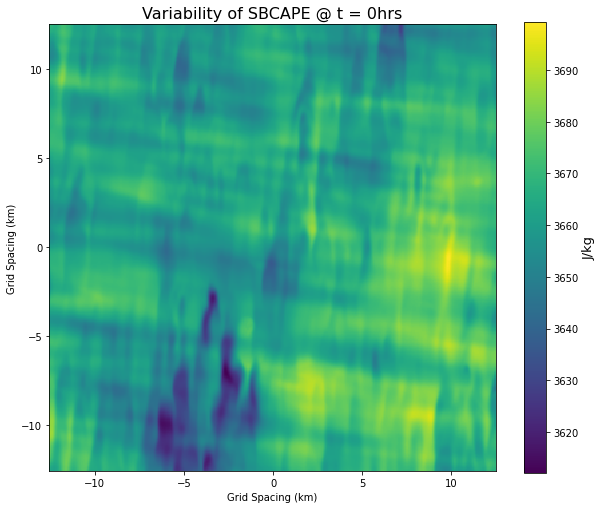

In [7]:
#CAPE

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.pcolormesh(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']], computations_data['CAPE'][0])
plt.title('Variability of SBCAPE @ t = 0hrs', fontsize = 16)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')

clb = plt.colorbar(shrink = 0.83)
clb.set_label('J/kg', fontsize = 13)
plt.gca().set_aspect('equal')


/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


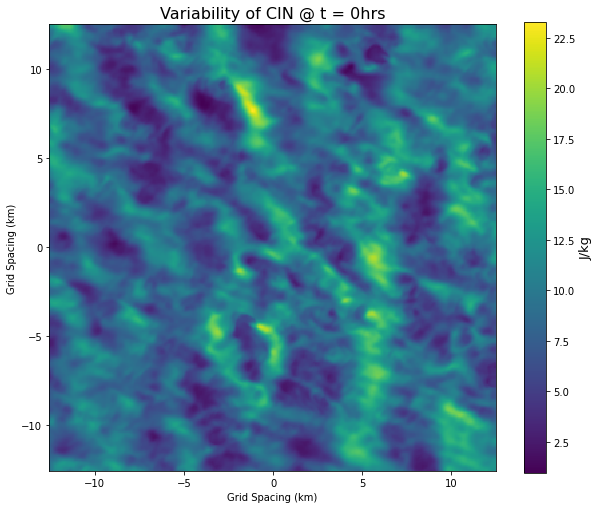

In [18]:
#CIN

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.pcolormesh(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']], computations_data['CIN'][0])
plt.title('Variability of CIN @ t = 0hrs', fontsize = 16)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
plt.gca().set_aspect('equal')
clb = plt.colorbar(shrink = 0.83)
clb.set_label('J/kg', fontsize = 13)

/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


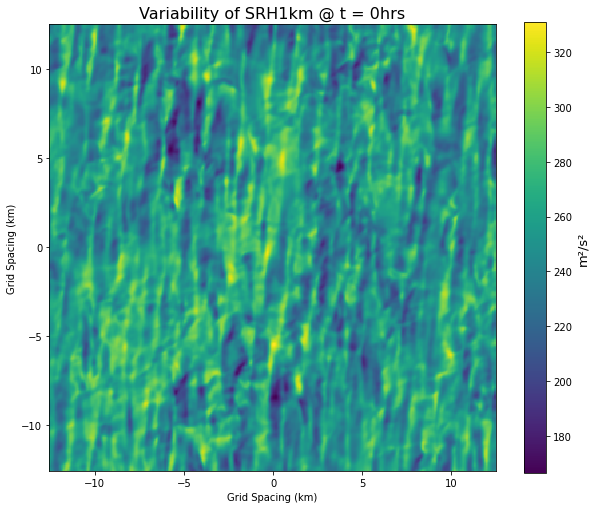

In [19]:
#SRH1km

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.pcolormesh(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']], computations_data['SRH1km'])
plt.title('Variability of SRH1km @ t = 0hrs', fontsize = 16)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
clb = plt.colorbar(shrink = 0.83)
clb.set_label('m\u00b2/s\u00b2', fontsize = 13)
plt.gca().set_aspect('equal')

/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


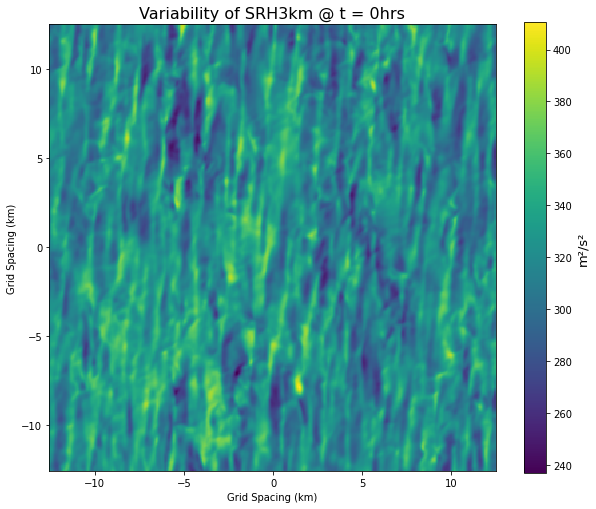

In [20]:
#SRH3km

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.pcolormesh(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']], computations_data['SRH3km'])
plt.title('Variability of SRH3km @ t = 0hrs', fontsize = 16)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
clb = plt.colorbar(shrink = 0.83)
clb.set_label('m\u00b2/s\u00b2', fontsize = 13)
plt.gca().set_aspect('equal')

/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


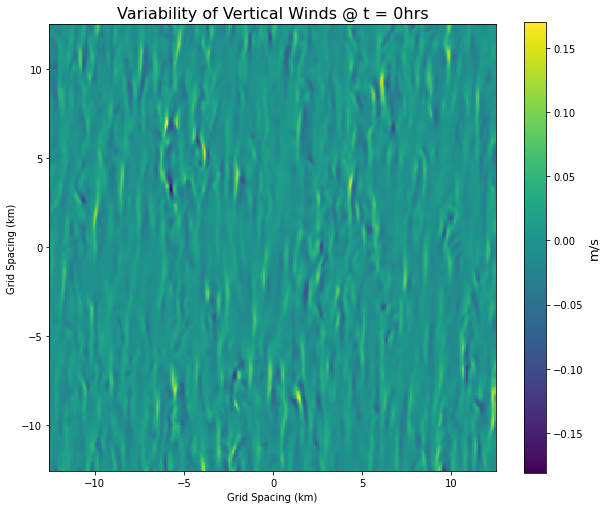

In [21]:
#w @ z = 7.5 m

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.pcolormesh(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']], computations_data['w_7.5'])
plt.title('Variability of Vertical Winds @ t = 0hrs', fontsize = 16)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
clb = plt.colorbar(shrink = 0.83)
clb.set_label('m/s', fontsize = 13)
plt.gca().set_aspect('equal')

/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


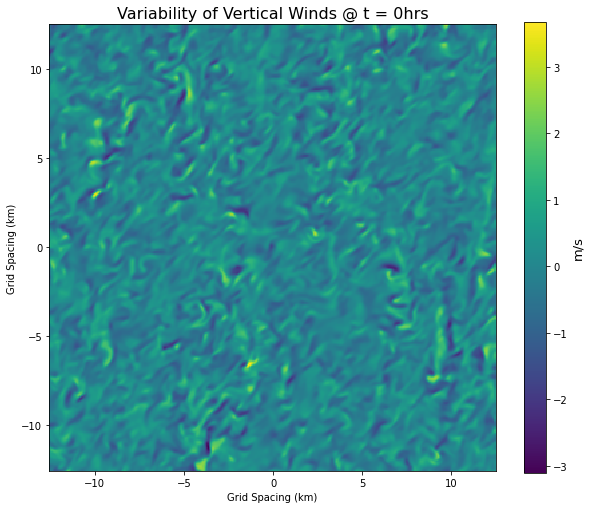

In [22]:
#w @ z = 500 m

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.pcolormesh(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']], computations_data['w_500'])
plt.title('Variability of Vertical Winds @ t = 0hrs', fontsize = 16)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
clb = plt.colorbar(shrink = 0.83)
clb.set_label('m/s', fontsize = 13)
plt.gca().set_aspect('equal')

/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


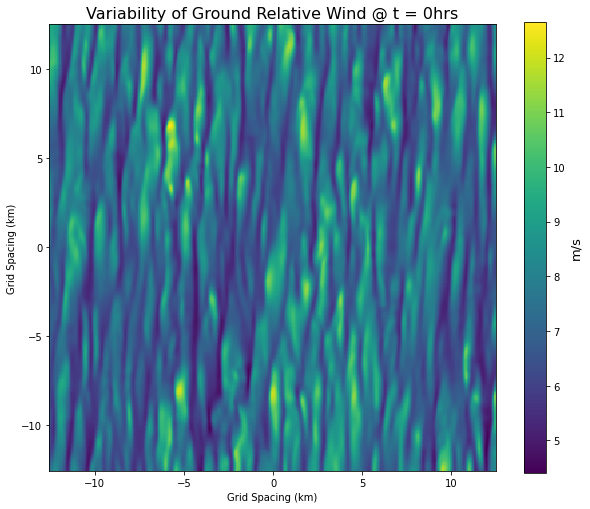

In [23]:
#Ground Relative Winds @ z = 7.5 m

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.pcolormesh(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']], gr_wind_75)
plt.title('Variability of Ground Relative Wind @ t = 0hrs', fontsize = 16)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
clb = plt.colorbar(shrink = 0.83)
clb.set_label('m/s', fontsize = 13)
plt.gca().set_aspect('equal')

/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


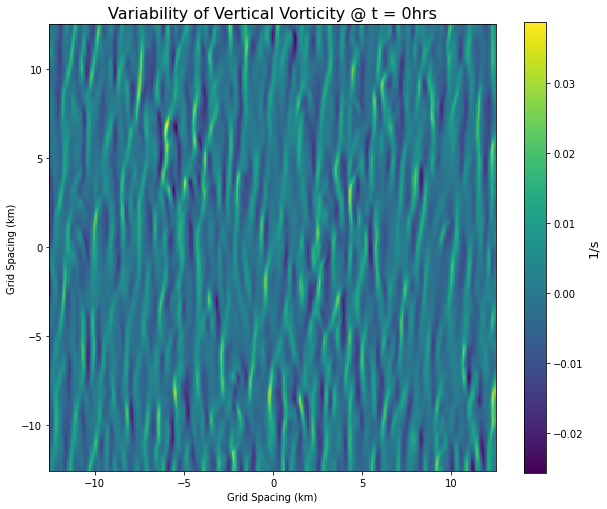

In [24]:
#vertical vorticity @ z = 7.5 m

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.pcolormesh(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']], vert_vort_75)
plt.title('Variability of Vertical Vorticity @ t = 0hrs', fontsize = 16)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
clb = plt.colorbar(shrink = 0.83)
clb.set_label('1/s', fontsize = 13)
plt.gca().set_aspect('equal')

/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


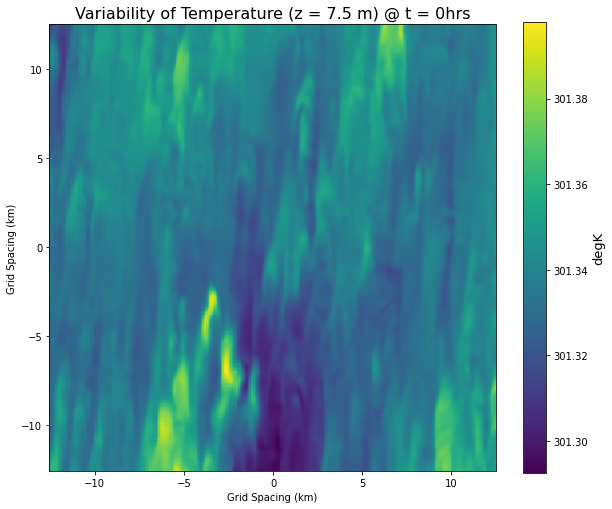

In [25]:
#Temperature @ z = 7.5 m

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.pcolormesh(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']], T_75)
plt.title('Variability of Temperature (z = 7.5 m) @ t = 0hrs', fontsize = 16)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
clb = plt.colorbar(shrink = 0.83)
clb.set_label('degK', fontsize = 13)
plt.gca().set_aspect('equal')

/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


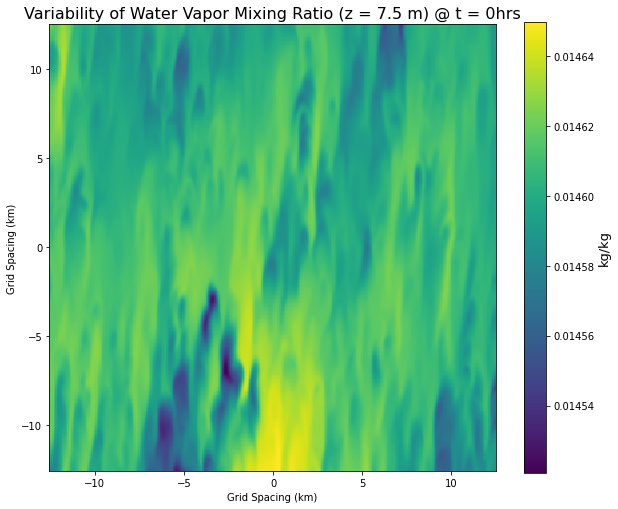

In [28]:
#Water Vapor Mixing Ratio @ z = 7.5 m

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.pcolormesh(x_data[computations_data['x-direction']], y_data[computations_data['y-direction']], qv_75)
plt.title('Variability of Water Vapor Mixing Ratio (z = 7.5 m) @ t = 0hrs', fontsize = 16)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
clb = plt.colorbar(shrink = 0.83)
clb.set_label('kg/kg', fontsize = 13)
plt.gca().set_aspect('equal')

# Bonus Task: Get Average of CAPE/CIN/SRH to get a Apples to Apples Comparison

In [16]:
#CAPE-CIN (Average Value over 25km x 25km Domain) 

#Import Data
QV_avg = storm16_data['qv'].loc[:,:,computations_data['y-direction'],computations_data['x-direction']][0].mean(axis=(1,2))
P_avg = storm16_data['prs'].loc[:,:,computations_data['y-direction'],computations_data['x-direction']][0].mean(axis=(1,2))/100
Th_avg = storm16_data['th'].loc[:,:,computations_data['y-direction'],computations_data['x-direction']][0].mean(axis=(1,2))

#For the WRF CAPE Function We Need: Total Pressure (hPa), Temperature (degK), Water Vapor Mixing Ratio (kg/kg), *Geopotential Height* (m), Terrain Height (m), Surface Pressure (hPa)
T_avg = mpcalc.temperature_from_potential_temperature(P_avg*units.hPa,Th_avg*units.kelvin) #Temperature from Potential Temperature
Height = np.asarray(z_data*1000).reshape(121) #"Geopotential Height"
Terrain = 0 #Terrain (Assuming Flat Surface)
P_sfc = P_avg[0] #Surface Pressure

#WRF CAPE Computation
results = wrf.cape_3d(P_avg,T_avg,QV_avg,Height,Terrain, P_sfc, ter_follow = True,meta= True)
CAPE_avg = results[0][0]
CIN_avg = results[1][0]


#SRH1km & SRH3km (Average Values over 25km x 25km Domain)

#Import Data
u_avg = storm16_data['uinterp'].loc[:,:,computations_data['y-direction'],computations_data['x-direction']][0].mean(axis=(1,2))
v_avg = storm16_data['vinterp'].loc[:,:,computations_data['y-direction'],computations_data['x-direction']][0].mean(axis=(1,2))

#For the WRF SRH Function We Need: U (m/s), V (m/s), Height (m), Terrain (m), Top (m)
SRH1km_avg = mpcalc.storm_relative_helicity(Height*units.meter, u_avg*units('m/s'),v_avg*units('m/s'), depth = 1000*units.meter)
SRH3km_avg = mpcalc.storm_relative_helicity(Height*units.meter, u_avg*units('m/s'),v_avg*units('m/s'), depth = 3000*units.meter)

#Average Vertical Winds
w_75_avg = computations_data['w_7.5'].mean().values
w_500_avg = computations_data['w_500'].mean().values


In [17]:
#Average Values
print(f'Avg. CAPE = {CAPE_avg.values} J/kg \nAvg. CIN = {CIN_avg.values} J/kg \nAvg. SRH1km = {SRH1km_avg[0]} \nAvg. SRH3km = {SRH3km_avg[0]}')


Avg. CAPE = 3663.61279296875 J/kg 
Avg. CIN = 8.797625541687012 J/kg 
Avg. SRH1km = 244.97998032731618 meter ** 2 / second ** 2 
Avg. SRH3km = 316.39872187702736 meter ** 2 / second ** 2


# **BoxPlots For the Data**

In [8]:
#First Need To Convert Our Dataframes to 1D Arrays
data_CAPE = np.asarray(computations_data['CAPE'][0]).reshape(computations_data['x-direction'].shape[0]*computations_data['x-direction'].shape[0])
data_CIN = np.asarray(computations_data['CIN'][0]).reshape(computations_data['x-direction'].shape[0]*computations_data['x-direction'].shape[0])
data_SRH1km = np.asarray(computations_data['SRH1km']).reshape(computations_data['x-direction'].shape[0]*computations_data['x-direction'].shape[0])
data_SRH3km = np.asarray(computations_data['SRH3km']).reshape(computations_data['x-direction'].shape[0]*computations_data['x-direction'].shape[0])
data_STP = np.asarray(computations_data['STP']).reshape(computations_data['x-direction'].shape[0]*computations_data['x-direction'].shape[0])
data_BWD = np.asarray(computations_data['BWD']).reshape(computations_data['x-direction'].shape[0]*computations_data['x-direction'].shape[0])
data_w_75 = np.asarray(computations_data['w_7.5']).reshape(computations_data['x-direction'].shape[0]*computations_data['x-direction'].shape[0])
data_w_500 = np.asarray(computations_data['w_500']).reshape(computations_data['x-direction'].shape[0]*computations_data['x-direction'].shape[0])
data_vert_vort_75 = data_vert_vort_75
data_gr_wind_75 = data_gr_wind_75
data_T_75 = np.asarray(T_75).reshape(computations_data['x-direction'].shape[0]*computations_data['x-direction'].shape[0])
data_qv_75 = np.asarray(qv_75).reshape(computations_data['x-direction'].shape[0]*computations_data['x-direction'].shape[0])



In [59]:
#Create Correlation Matrix

#Assemble the Data
data = {
    'CAPE':data_CAPE,
    'CIN':data_CIN,
    'SRH1km':data_SRH1km,
    'SRH3km':data_SRH3km,
    'STP': data_STP,
    'BWD': data_BWD,
    'w_75':data_w_75,
    'w_522':data_w_500,
    'gr_wind':data_gr_wind_75,
    'zvort':data_vert_vort_75,
    'T':data_T_75,
    'qv':data_qv_75
}

dataframe = pd.DataFrame(data, columns=['CAPE','CIN','SRH1km','SRH3km','STP','BWD','w_75','w_522','gr_wind','zvort','T','qv'])

#Create the Matrix
matrix = dataframe.corr()
matrix

CAPE       CIN    SRH1km    SRH3km       STP       BWD      w_75  \
CAPE     1.000000 -0.024015  0.025286  0.015856  0.049780  0.030888 -0.003929   
CIN     -0.024015  1.000000  0.141117 -0.164910  0.247473 -0.024148 -0.024309   
SRH1km   0.025286  0.141117  1.000000  0.911477  0.983095  0.724837  0.310852   
SRH3km   0.015856 -0.164910  0.911477  1.000000  0.876007  0.758560  0.324551   
STP      0.049780  0.247473  0.983095  0.876007  1.000000  0.794078  0.330274   
BWD      0.030888 -0.024148  0.724837  0.758560  0.794078  1.000000  0.400447   
w_75    -0.003929 -0.024309  0.310852  0.324551  0.330274  0.400447  1.000000   
w_522    0.028066 -0.161697 -0.047259 -0.015529 -0.070780 -0.043031  0.107305   
gr_wind -0.129674 -0.037198 -0.682376 -0.690146 -0.709273 -0.710726 -0.413787   
zvort   -0.046405 -0.021167 -0.032792 -0.033478  0.021776  0.256111  0.224017   
T       -0.489087 -0.014539 -0.111993 -0.142827 -0.128382 -0.103072  0.021307   
qv       0.526044  0.014286  0.156557  0.174515  0.173458  0.141151 -0.017994   

            w_522   gr_wind     zvort         T        qv  
CAPE     0.028066 -0.129674 -0.046405 -0.489087  0.526044  
CIN     -0.161697 -0.037198 -0.021167 -0.014539  0.014286  
SRH1km  -0.047259 -0.682376 -0.032792 -0.111993  0.156557  
SRH3km  -0.015529 -0.690146 -0.033478 -0.142827  0.174515  
STP     -0.070780 -0.709273  0.021776 -0.128382  0.173458  
BWD     -0.043031 -0.710726  0.256111 -0.103072  0.141151  
w_75     0.107305 -0.413787  0.224017  0.021307 -0.017994  
w_522    1.000000 -0.060214 -0.013384 -0.020209  0.032789  
gr_wind -0.060214  1.000000  0.030010  0.120959 -0.232139  
zvort   -0.013384  0.030010  1.000000  0.063078 -0.079904  
T       -0.020209  0.120959  0.063078  1.000000 -0.965233  
qv       0.032789 -0.232139 -0.079904 -0.965233  1.000000

In [38]:
print(f'{data_CAPE.mean()}, {data_CAPE.var()}')
print(f'{data_CIN.mean()}, {data_CIN.var()}')
print(f'{data_SRH1km.mean()}, {data_SRH1km.var()}')
print(f'{data_SRH3km.mean()}, {data_SRH3km.var()}')
print(f'{data_gr_wind_75.mean()}, {data_gr_wind_75.var()}')
print(f'{data_vert_vort_75.mean()}, {data_vert_vort_75.var()}')


3663.70654296875, 126.30231475830078
8.874866485595703, 10.504850387573242
253.5675506591797, 512.6649780273438
320.3332214355469, 469.39837646484375
7.369382381439209, 1.5124621391296387
1.9478893591440283e-06, 4.4378040911396965e-05


In [39]:
# Compute Statistics (Mean and STD)

print(f'CAPE: mean_p = {np.e}mean difference = {np.mean(data_CAPE)}, std = {np.std(data_CAPE)}, min = {np.min(data_CAPE)}, max = {np.max(data_CAPE)}')
print(f'CIN: mean difference = {np.mean(data_CIN)}, std = {np.std(data_CIN)}, min = {np.min(data_CIN)}, max = {np.max(data_CIN)}')
print(f'SRH1km: mean difference = {np.mean(data_SRH1km)}, std = {np.std(data_SRH1km)}, min = {np.min(data_SRH1km)}, max = {np.max(data_SRH1km)}')
print(f'SRH3km: mean difference = {np.mean(data_SRH3km)}, std = {np.std(data_SRH3km)}, min = {np.min(data_SRH3km)}, max = {np.max(data_SRH3km)}')
print(f'BWD: mean difference = {np.mean(data_BWD)}, std = {np.std(data_BWD)}, min = {np.min(data_BWD)}, max = {np.max(data_BWD)}')
print(f'STP: mean difference = {np.mean(data_STP)}, std = {np.std(data_STP)}, min = {np.min(data_STP)}, max = {np.max(data_STP)}')





CAPE: mean = 3663.70654296875, std = 11.23843002319336, min = 3612.018310546875, max = 3699.305908203125
CIN: mean = 8.874866485595703, std = 3.2411186695098877, min = 0.9578457474708557, max = 23.27726936340332
SRH1km: mean = 253.5675506591797, std = 22.642107009887695, min = 166.39910888671875, max = 330.9811096191406
SRH3km: mean = 320.3332214355469, std = 21.665603637695312, min = 236.850341796875, max = 410.61114501953125
BWD: mean = 27.75638198852539, std = 0.6574941873550415, min = 23.953563690185547, max = 30.667329788208008
STP: mean = 6.806921482086182, std = 0.7483737468719482, min = 3.9737534523010254, max = 9.5161771774292


In [17]:
np.var(data_BWD)

0.43229863

In [19]:
params = [data_CAPE, data_CIN, data_SRH1km, data_SRH3km, data_BWD, data_STP]
param_names = ['CAPE', 'CIN', 'SRH1km', 'SRH3km', 'BWD', 'STP']
for x in range(len(params)):
    data_range = (np.max(params[x]) - np.min(params[x]))/(np.mean(params[x]))
    print(f'{param_names[x]}: {data_range}')
    

CAPE: 0.023824943229556084
CIN: 2.5149025917053223
SRH1km: 0.6490657329559326
SRH3km: 0.5424376726150513
BWD: 0.24188189208507538
STP: 0.8142335414886475


Text(0.5, 1.0, 'STP')

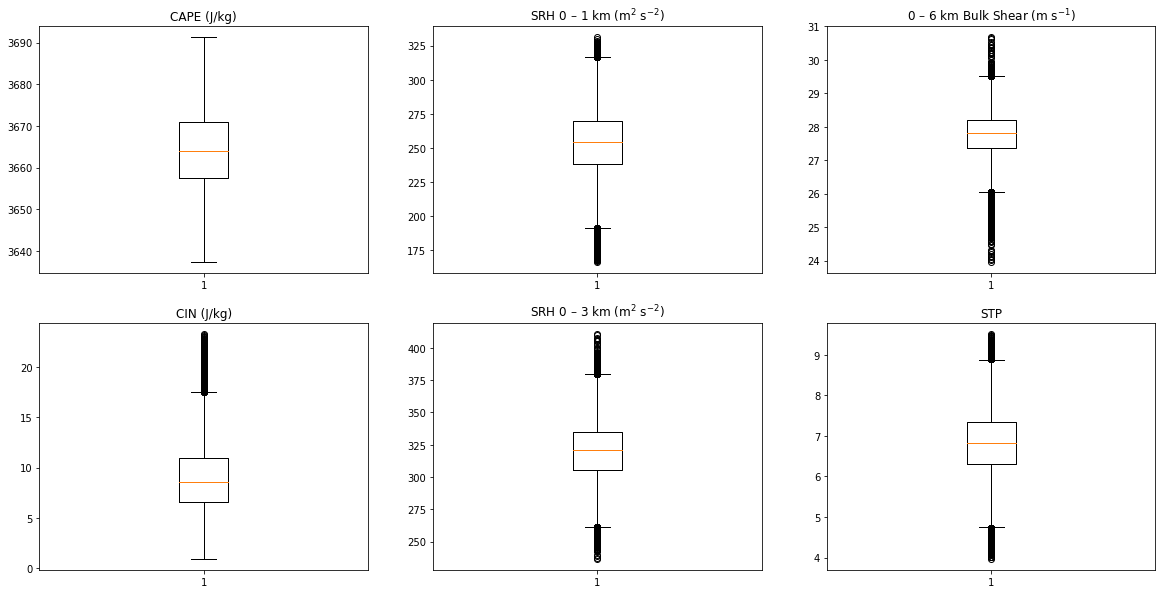

In [27]:
#Plot Box and Whisker Plots For ALL Parameters (w/ Outlier Points)

fig, axs = plt.subplots(nrows =2, ncols = 3, figsize = (20,10))

#fig.suptitle('Variability in Forecasting Parameters & Other Relevant Variables (t = 0 hrs)')
#CAPE
axs[0,0].boxplot(data_CAPE,0, '')
axs[0,0].set_title('CAPE (J/kg)')


#CIN
axs[1,0].boxplot(data_CIN)
axs[1,0].set_title('CIN (J/kg)')

#SRH1km 
axs[0,1].boxplot(data_SRH1km)
axs[0,1].set_title('SRH 0 – 1 km (m$^2$ s$^{-2}$)')

#SRH3km
axs[1,1].boxplot(data_SRH3km)
axs[1,1].set_title('SRH 0 – 3 km (m$^2$ s$^{-2}$)')

#w_7.5
#axs[0,2].boxplot(data_w_75)
#axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w_500
#axs[1,2].boxplot(data_w_500)
#axs[1,2].set_title('w @ z = 500 m (m/s)')

#Ground Relative Wind 
axs[0,2].boxplot(data_BWD)
axs[0,2].set_title('0 – 6 km Bulk Shear (m s$^{-1}$)')

#Vertical Vorticity 
axs[1,2].boxplot(data_STP)
axs[1,2].set_title('STP')

#Temperature 
#axs[0,4].boxplot(data_T_75)
#axs[0,4].set_title('Temp. @ z = 7.5 m (degK)')

#Water Vapor Mixing Ratio
#axs[1,4].boxplot(data_qv_75)
#axs[1,4].set_title('WV Mixing Ratio @ z = 7.5 m (kg/kg)')

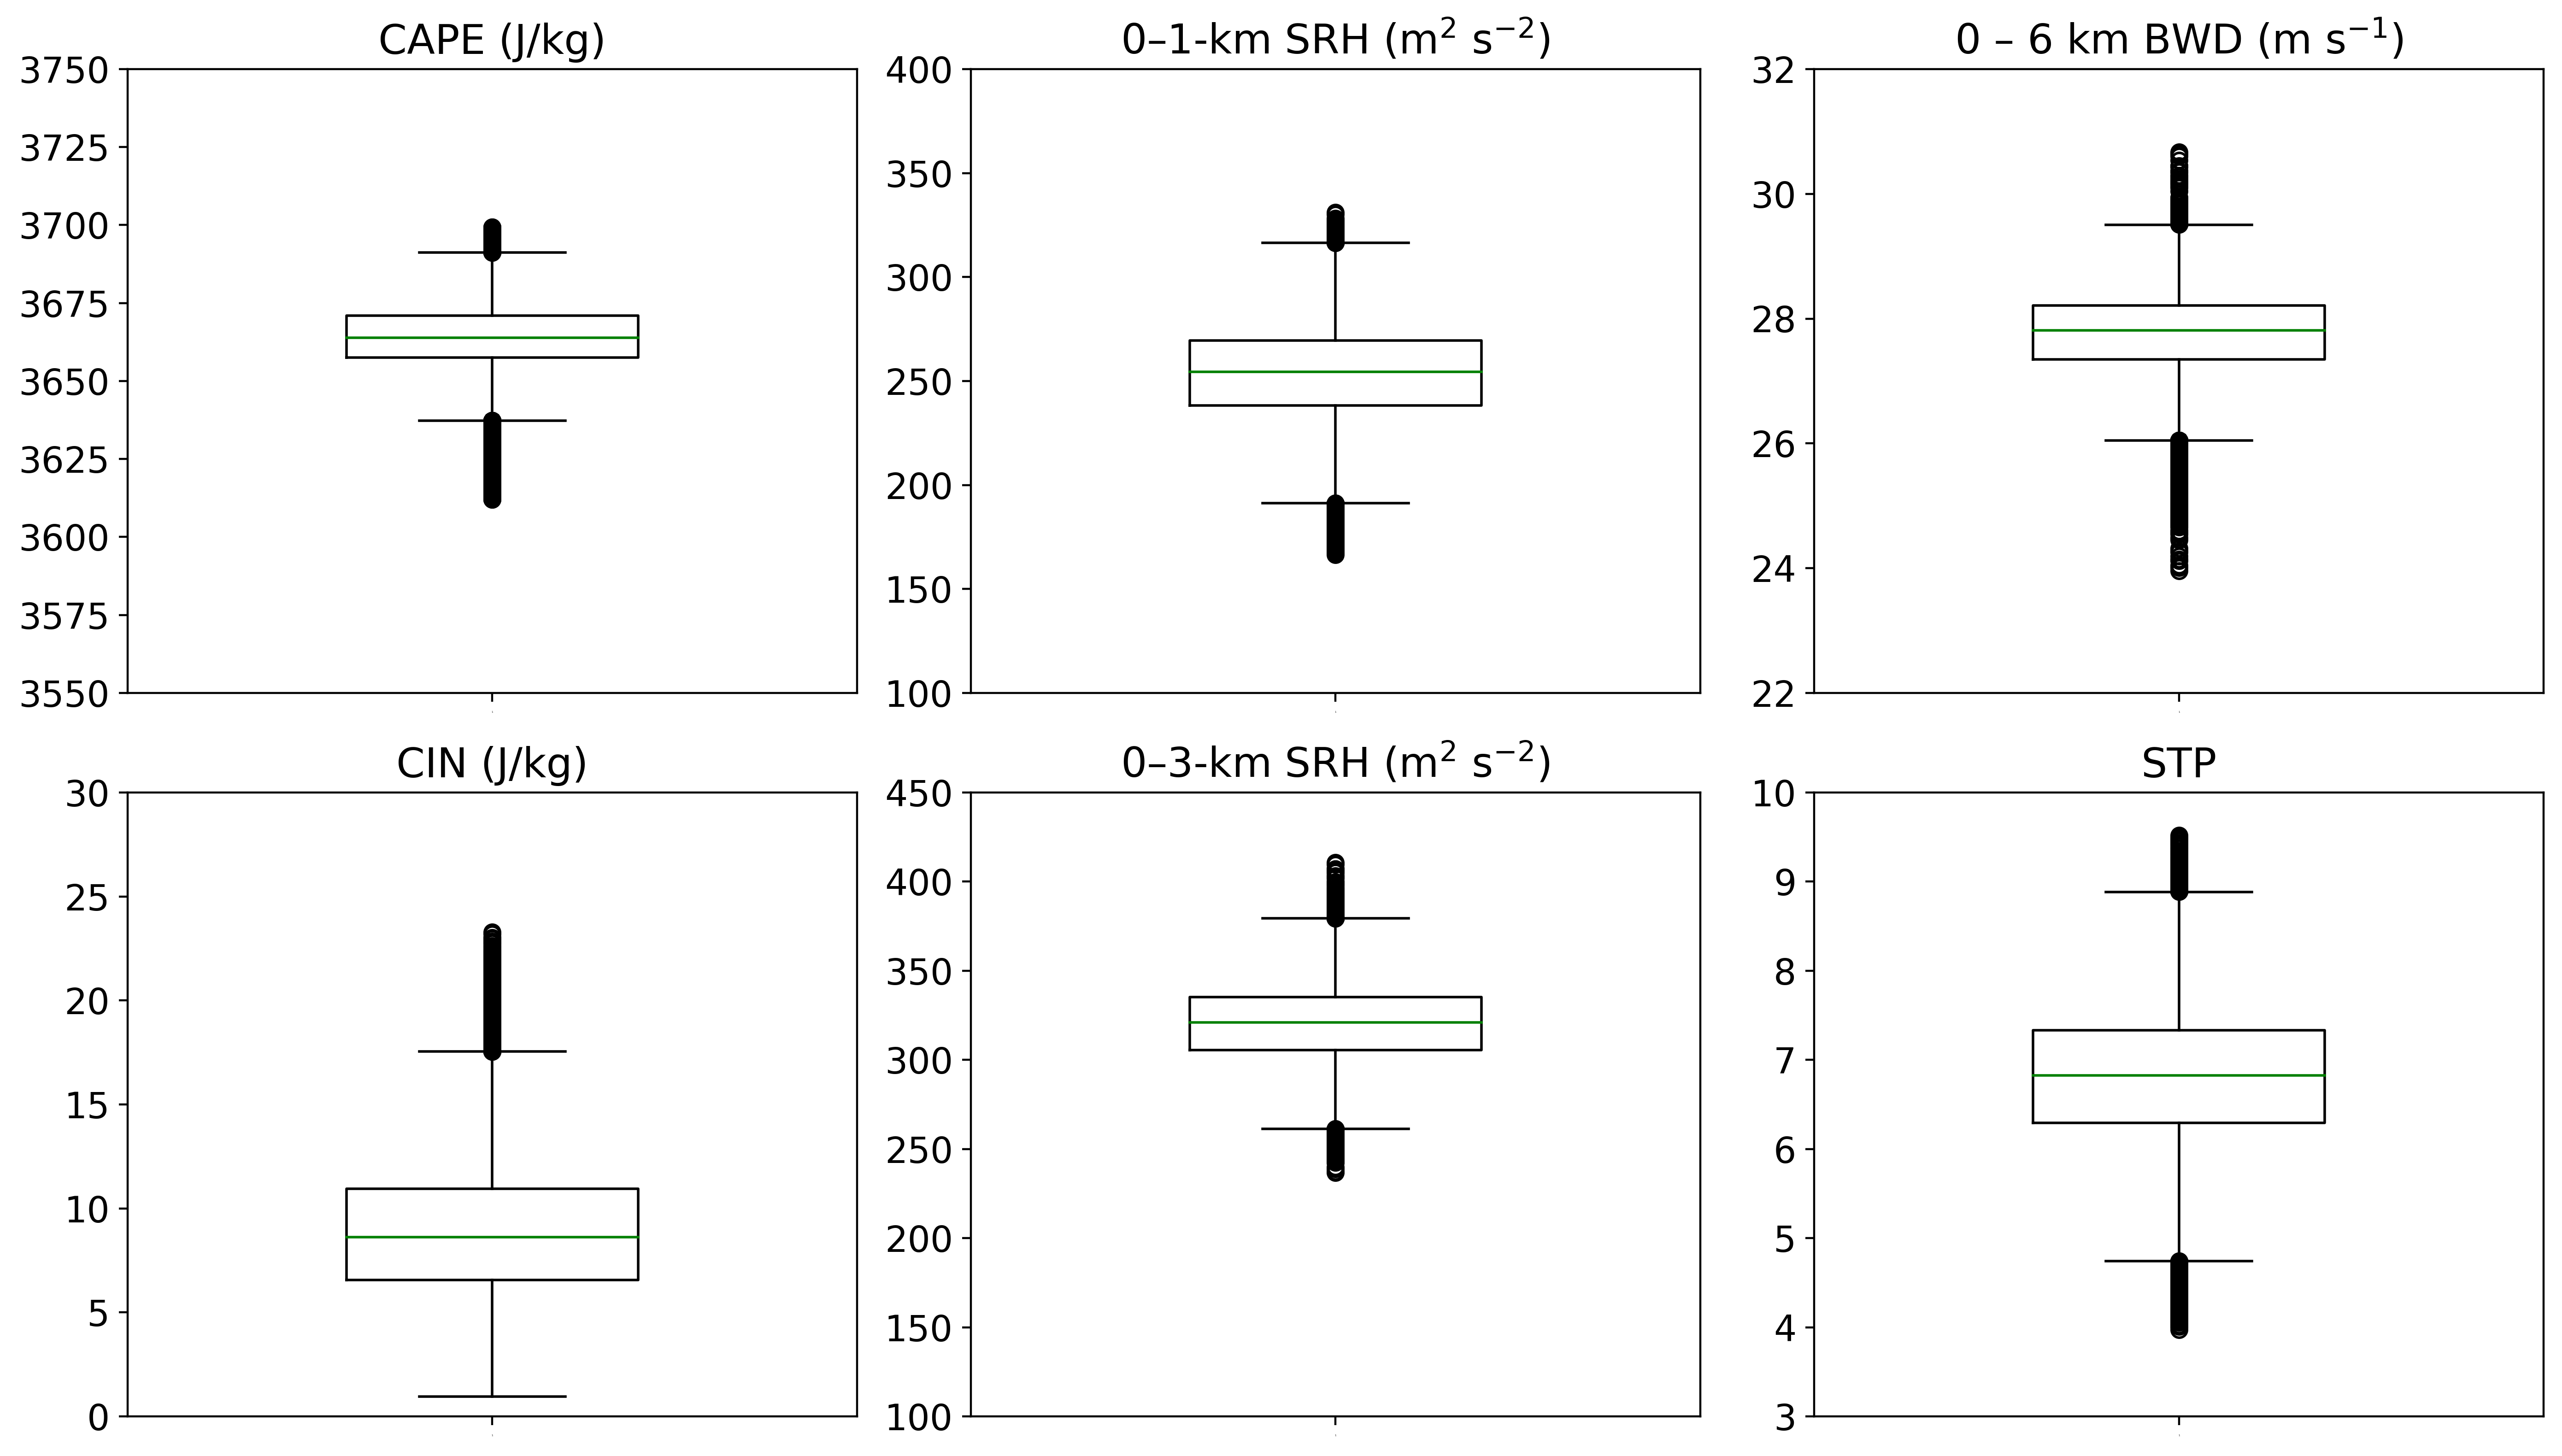

In [36]:
#Plot Box and Whisker Plots For ALL Parameters (w/o Outlier Points)

fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (14,8), dpi=400)
plt.subplots_adjust(wspace=0.05, hspace=0.2)


medianprops = dict(color='green')

#CAPE
axs[0,0].boxplot(data_CAPE, medianprops = medianprops, widths = 0.4)
#axs[0,0].scatter(1,CAPE_avg.values,color='green')
axs[0,0].set_title('CAPE (J/kg)', fontsize=16)
axs[0,0].tick_params(axis='y', labelsize=14)
axs[0,0].tick_params(axis='x', labelsize=0)
axs[0,0].set_ylim(3550,3750)

#CIN
axs[1,0].boxplot(data_CIN,medianprops = medianprops,  widths = 0.4)
#axs[1,0].scatter(1,CIN_avg.values,color='green')
axs[1,0].set_title('CIN (J/kg)', fontsize=16)
axs[1,0].tick_params(axis='y', labelsize=14)
axs[1,0].tick_params(axis='x', labelsize=0)
axs[1,0].set_ylim(0,30)

#SRH1km 
axs[0,1].boxplot(data_SRH1km, medianprops = medianprops,  widths = 0.4)
#axs[0,1].boxplot(data_SRH1km, 0, '',medianprops = medianprops,  widths = 0.4)
#axs[0,1].scatter(1,SRH1km_avg[0],color='green')
axs[0,1].set_title('0–1-km SRH (m$^2$ s$^{-2}$)', fontsize=16)
axs[0,1].tick_params(axis='y', labelsize=14)
axs[0,1].tick_params(axis='x', labelsize=0)
axs[0,1].set_ylim(100,400)

#SRH3km
axs[1,1].boxplot(data_SRH3km, medianprops = medianprops,  widths = 0.4)
#axs[1,1].scatter(1,SRH3km_avg[0],color='green')
axs[1,1].set_title('0–3-km SRH (m$^2$ s$^{-2}$)', fontsize=16)
axs[1,1].tick_params(axis='y', labelsize=14)
axs[1,1].tick_params(axis='x', labelsize=0)
axs[1,1].set_ylim(100,450)


#w_7.5
#axs[0,2].boxplot(data_w_75, 0, '',medianprops = medianprops,  widths = 0.4)
#axs[0,2].scatter(1,w_75_avg,color='green')
#axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w_500
#axs[1,2].boxplot(data_w_500, 0, '',medianprops = medianprops,  widths = 0.4)
#axs[1,2].scatter(1,w_500_avg,color='green')
#axs[1,2].set_title('w @ z = 500 m (m/s)')

#Ground Relative Wind 
axs[0,2].boxplot(data_BWD,medianprops = medianprops,  widths = 0.4)
axs[0,2].set_title('0 – 6 km BWD (m s$^{-1}$)', fontsize=16)
axs[0,2].tick_params(axis='y', labelsize=14)
axs[0,2].tick_params(axis='x', labelsize=0)
axs[0,2].set_ylim(22, 32)

#STP 
axs[1,2].boxplot(data_STP,medianprops = medianprops,  widths = 0.4)
axs[1,2].set_title('STP', fontsize=16)
axs[1,2].tick_params(axis='y', labelsize=14)
axs[1,2].tick_params(axis='x', labelsize=0)
axs[1,2].set_ylim(3,10)

#Temperature 
#axs[0,4].boxplot(data_T_75, 0 , '',medianprops = medianprops,  widths = 0.4)
#axs[0,4].set_title('Temp. @ z = 7.5 m (degK)')
#axs[0,4].set_ylim(301.3,301.37)

#Water Vapor Mixing Ratio
#axs[1,4].boxplot(data_qv_75, 0 , '', widths = 0.4)
#axs[1,4].set_title('WV Mixing Ratio @ z = 7.5 m (kg/kg)')

# Add text labels to each top right corner
# fig.text(0.02, 0.97, 'a)', fontsize = 14, weight = 'demibold')
# fig.text(0.35, 0.97, 'b)', fontsize = 14, weight = 'demibold')
# fig.text(0.68, 0.97, 'c)', fontsize = 14, weight = 'demibold')
# fig.text(0.02, 0.48, 'd)', fontsize = 14, weight = 'demibold')
# fig.text(0.35, 0.48, 'e)', fontsize = 14, weight = 'demibold')
# fig.text(0.68, 0.48, 'f)', fontsize = 14, weight = 'demibold')


plt.tight_layout()
plt.show()

In [14]:
def stats_calc(dataset):
    std = (dataset.max()-dataset.min())/4
    mean = dataset.mean()
    return mean, std;

In [43]:
computations_data

<xarray.Dataset>
Dimensions:      (dim_0: 335, dim_1: 335, ni: 335, nj: 335, nk: 121)
Coordinates:
    x-direction  (ni) int64 682 683 684 685 686 687 ... 1012 1013 1014 1015 1016
    y-direction  (nj) int64 682 683 684 685 686 687 ... 1012 1013 1014 1015 1016
    z-direction  (nk) int64 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119 120
Dimensions without coordinates: dim_0, dim_1, ni, nj, nk
Data variables:
    CAPE         (nk, nj, ni) float32 ...
    CIN          (nk, nj, ni) float32 ...
    SRH1km       (dim_0, dim_1) float32 262.9 255.9 246.6 ... 256.8 243.9 244.2
    SRH3km       (dim_0, dim_1) float32 328.1 320.6 311.0 ... 311.3 298.7 299.3
    w_7.5        (nj, ni) float32 ...
    w_500        (nj, ni) float32 ...
    STP          (nj, ni) float32 7.155 6.896 6.575 6.266 ... 7.003 6.575 6.58
    BWD          (nj, ni) float32 28.18 27.86 27.49 27.12 ... 27.89 27.57 27.56

# **Correlation Plots**

In [21]:
#SBCAPE With Other Variables

corr_CAPE_CIN = np.corrcoef(data_CAPE, data_CIN)[0][1]
corr_CAPE_SRH1km = np.corrcoef(data_CAPE, data_SRH1km)[0][1]
corr_CAPE_SRH3km = np.corrcoef(data_CAPE, data_SRH3km)[0][1]
corr_CAPE_w75 = np.corrcoef(data_CAPE, data_w_75)[0][1]
corr_CAPE_w500 = np.corrcoef(data_CAPE, data_w_500)[0][1]
corr_CAPE_gr_wind_75 = np.corrcoef(data_CAPE, data_gr_wind_75)[0][1]
corr_CAPE_vert_vort_75 = np.corrcoef(data_CAPE, data_vert_vort_75)[0][1]
corr_CAPE_T_75 = np.corrcoef(data_CAPE, data_T_75)[0][1]
corr_CAPE_qv_75 = np.corrcoef(data_CAPE, data_qv_75)[0][1]

print(f'CAPE & CIN = {corr_CAPE_CIN} \nCAPE & SRH1km = {corr_CAPE_SRH1km} \nCAPE & SRH3km = {corr_CAPE_SRH3km} \nCAPE & w_7.5m = {corr_CAPE_w75} \nCAPE & w_500m = {corr_CAPE_w500} \nCAPE & gr_wind75 = {corr_CAPE_gr_wind_75} \nCAPE & vert_vort75 = {corr_CAPE_vert_vort_75} \nCAPE & T_75 = {corr_CAPE_T_75} \nCAPE & qv_75 = {corr_CAPE_qv_75}')

CAPE & CIN = -0.02401495813888891 
CAPE & SRH1km = 0.025285585517193093 
CAPE & SRH3km = 0.015855969922893683 
CAPE & w_7.5m = -0.003929181897349239 
CAPE & w_500m = 0.02806607507763663 
CAPE & gr_wind75 = -0.1296743308841297 
CAPE & vert_vort75 = -0.046405211025741945 
CAPE & T_75 = -0.48908679324672594 
CAPE & qv_75 = 0.5260437822711148


In [22]:
#CIN With Other Variables

corr_CIN_CAPE = np.corrcoef(data_CIN, data_CAPE)[0][1]
corr_CIN_SRH1km = np.corrcoef(data_CIN, data_SRH1km)[0][1]
corr_CIN_SRH3km = np.corrcoef(data_CIN, data_SRH3km)[0][1]
corr_CIN_w75 = np.corrcoef(data_CIN, data_w_75)[0][1]
corr_CIN_w500 = np.corrcoef(data_CIN, data_w_500)[0][1]
corr_CIN_gr_wind_75 = np.corrcoef(data_CIN, data_gr_wind_75)[0][1]
corr_CIN_vert_vort_75 = np.corrcoef(data_CIN, data_vert_vort_75)[0][1]
corr_CIN_T_75 = np.corrcoef(data_CIN, data_T_75)[0][1]
corr_CIN_qv_75 = np.corrcoef(data_CIN, data_qv_75)[0][1]


print(f'CIN & CAPE = {corr_CIN_CAPE} \nCIN & SRH1km = {corr_CIN_SRH1km} \nCIN & SRH3km = {corr_CIN_SRH3km} \nCIN & w_7.5m = {corr_CIN_w75} \nCIN & w_500m = {corr_CIN_w500} \nCIN & gr_wind75 = {corr_CIN_gr_wind_75} \nCIN & vert_vort75 = {corr_CIN_vert_vort_75} \nCIN & T_75 = {corr_CIN_T_75} \nCIN & qv_75 = {corr_CIN_qv_75}')

CIN & CAPE = -0.024014958138888917 
CIN & SRH1km = 0.14111714068093437 
CIN & SRH3km = -0.1649099833133503 
CIN & w_7.5m = -0.024308730436549606 
CIN & w_500m = -0.16169749530198518 
CIN & gr_wind75 = -0.03719778912079023 
CIN & vert_vort75 = -0.02116747714448257 
CIN & T_75 = -0.014539466276529406 
CIN & qv_75 = 0.014285516882002289


In [23]:
#SRH1km With Other Variables

corr_SRH1km_CAPE = np.corrcoef(data_SRH1km, data_CAPE)[0][1]
corr_SRH1km_CIN = np.corrcoef(data_SRH1km, data_CIN)[0][1]
corr_SRH1km_SRH3km = np.corrcoef(data_SRH1km, data_SRH3km)[0][1]
corr_SRH1km_w75 = np.corrcoef(data_SRH1km, data_w_75)[0][1]
corr_SRH1km_w500 = np.corrcoef(data_SRH1km, data_w_500)[0][1]
corr_SRH1km_gr_wind_75 = np.corrcoef(data_SRH1km, data_gr_wind_75)[0][1]
corr_SRH1km_vert_vort_75 = np.corrcoef(data_SRH1km, data_vert_vort_75)[0][1]
corr_SRH1km_T_75 = np.corrcoef(data_SRH1km, data_T_75)[0][1]
corr_SRH1km_qv_75 = np.corrcoef(data_SRH1km, data_qv_75)[0][1]


print(f'SRH1km & CAPE = {corr_SRH1km_CAPE} \nSRH1km & CIN = {corr_SRH1km_CIN} \nSRH1km & SRH3km = {corr_SRH1km_SRH3km} \nSRH1km & w_7.5m = {corr_SRH1km_w75} \nSRH1km & w_500m = {corr_SRH1km_w500}\nSRH1km & gr_wind75 = {corr_SRH1km_gr_wind_75} \nSRH1km & vert_vort75 = {corr_SRH1km_vert_vort_75} \nSRH1km & T_75 = {corr_SRH1km_T_75} \nSRH1km & qv_75 = {corr_SRH1km_qv_75} ')

SRH1km & CAPE = 0.025285585517193093 
SRH1km & CIN = 0.14111714068093437 
SRH1km & SRH3km = 0.9114772592936853 
SRH1km & w_7.5m = 0.3108515963274099 
SRH1km & w_500m = -0.04725925050512548
SRH1km & gr_wind75 = -0.68237603608488 
SRH1km & vert_vort75 = -0.03279177502700991 
SRH1km & T_75 = -0.11199280154624545 
SRH1km & qv_75 = 0.15655666532972173 


In [24]:
#SRH3km With Other Variables

corr_SRH3km_CAPE = np.corrcoef(data_SRH3km, data_CAPE)[0][1]
corr_SRH3km_CIN = np.corrcoef(data_SRH3km, data_CIN)[0][1]
corr_SRH3km_SRH1km = np.corrcoef(data_SRH3km, data_SRH1km)[0][1]
corr_SRH3km_w75 = np.corrcoef(data_SRH3km, data_w_75)[0][1]
corr_SRH3km_w500 = np.corrcoef(data_SRH3km, data_w_500)[0][1]
corr_SRH3km_gr_wind_75 = np.corrcoef(data_SRH3km, data_gr_wind_75)[0][1]
corr_SRH3km_vert_vort_75 = np.corrcoef(data_SRH3km, data_vert_vort_75)[0][1]
corr_SRH3km_T_75 = np.corrcoef(data_SRH3km, data_T_75)[0][1]
corr_SRH3km_qv_75 = np.corrcoef(data_SRH3km, data_qv_75)[0][1]


print(f'SRH3km & CAPE = {corr_SRH3km_CAPE} \nSRH3km & CIN = {corr_SRH3km_CIN} \nSRH3km & SRH1km = {corr_SRH3km_SRH1km} \nSRH3km & w_7.5m = {corr_SRH3km_w75} \nSRH3km & w_500m = {corr_SRH3km_w500} \nSRH3km & gr_wind75 = {corr_SRH3km_gr_wind_75} \nSRH3km & vert_vort75 = {corr_SRH3km_vert_vort_75} \nSRH3km & T_75 = {corr_SRH3km_T_75} \nSRH3km & qv_75 = {corr_SRH3km_qv_75} ')

SRH3km & CAPE = 0.015855969922893686 
SRH3km & CIN = -0.16490998331335033 
SRH3km & SRH1km = 0.9114772592936852 
SRH3km & w_7.5m = 0.324550626060289 
SRH3km & w_500m = -0.015529337296299149 
SRH3km & gr_wind75 = -0.6901456476755771 
SRH3km & vert_vort75 = -0.03347835486160647 
SRH3km & T_75 = -0.1428270905294727 
SRH3km & qv_75 = 0.174515251687008 


In [25]:
#w_75 With Other Variables

corr_w75_CAPE = np.corrcoef(data_w_75, data_CAPE)[0][1]
corr_w75_CIN = np.corrcoef(data_w_75, data_CIN)[0][1]
corr_w75_SRH1km = np.corrcoef(data_w_75, data_SRH1km)[0][1]
corr_w75_SRH3km = np.corrcoef(data_w_75, data_SRH3km)[0][1]
corr_w75_w500 = np.corrcoef(data_w_75, data_w_500)[0][1]
corr_w75_gr_wind_75 = np.corrcoef(data_w_75, data_gr_wind_75)[0][1]
corr_w75_vert_vort_75 = np.corrcoef(data_w_75, data_vert_vort_75)[0][1]
corr_w75_T_75 = np.corrcoef(data_w_75, data_T_75)[0][1]
corr_w75_qv_75 = np.corrcoef(data_w_75, data_qv_75)[0][1]



print(f'w_75 & CAPE = {corr_w75_CAPE} \nw_75 & CIN = {corr_w75_CIN} \nw_75 & SRH1km = {corr_w75_SRH1km} \nw_75 & SRH3km = {corr_w75_SRH3km} \nw_75 & w_500m = {corr_w75_w500} \nw_75 & gr_wind75 = {corr_w75_gr_wind_75} \nw_75 & vert_vort75 = {corr_w75_vert_vort_75} \nw_75 & T_75 = {corr_w75_T_75} \nw_75 & qv_75 = {corr_w75_qv_75}')

w_75 & CAPE = -0.003929181897349239 
w_75 & CIN = -0.024308730436549603 
w_75 & SRH1km = 0.31085159632740983 
w_75 & SRH3km = 0.324550626060289 
w_75 & w_500m = 0.10730523267366926 
w_75 & gr_wind75 = -0.4137867509465824 
w_75 & vert_vort75 = 0.22401746865715721 
w_75 & T_75 = 0.02130651392592393 
w_75 & qv_75 = -0.01799358693206094


In [26]:
#w_500 With Other Variables

corr_w500_CAPE = np.corrcoef(data_w_500, data_CAPE)[0][1]
corr_w500_CIN = np.corrcoef(data_w_500, data_CIN)[0][1]
corr_w500_SRH1km = np.corrcoef(data_w_500, data_SRH1km)[0][1]
corr_w500_SRH3km = np.corrcoef(data_w_500, data_SRH3km)[0][1]
corr_w500_w75 = np.corrcoef(data_w_500, data_w_75)[0][1]
corr_w500_gr_wind_75 = np.corrcoef(data_w_500, data_gr_wind_75)[0][1]
corr_w500_vert_vort_75 = np.corrcoef(data_w_500, data_vert_vort_75)[0][1]
corr_w500_T_75 = np.corrcoef(data_w_500, data_T_75)[0][1]
corr_w500_qv_75 = np.corrcoef(data_w_500, data_qv_75)[0][1]


print(f'w_500 & CAPE = {corr_w500_CAPE} \nw_500 & CIN = {corr_w500_CIN} \nw_500 & SRH1km = {corr_w500_SRH1km} \nw_500 & SRH3km = {corr_w500_SRH3km} \nw_500 & w_75m = {corr_w500_w75} \nw_500 & gr_wind75 = {corr_w500_gr_wind_75} \nw_500 & vert_vort75 = {corr_w500_vert_vort_75} \nw_500 & T_75 = {corr_w500_T_75} \nw_500 & qv_75 = {corr_w500_qv_75}')

w_500 & CAPE = 0.02806607507763663 
w_500 & CIN = -0.1616974953019852 
w_500 & SRH1km = -0.04725925050512548 
w_500 & SRH3km = -0.015529337296299149 
w_500 & w_75m = 0.10730523267366926 
w_500 & gr_wind75 = -0.06021389081340026 
w_500 & vert_vort75 = -0.013384359303180483 
w_500 & T_75 = -0.02020861430560568 
w_500 & qv_75 = 0.032788559542649434


In [27]:
#gr_wind75 With Other Variables

corr_gr_wind75_CAPE = np.corrcoef(data_gr_wind_75, data_CAPE)[0][1]
corr_gr_wind75_CIN = np.corrcoef(data_gr_wind_75, data_CIN)[0][1]
corr_gr_wind75_SRH1km = np.corrcoef(data_gr_wind_75, data_SRH1km)[0][1]
corr_gr_wind75_SRH3km = np.corrcoef(data_gr_wind_75, data_SRH3km)[0][1]
corr_gr_wind75_w75 = np.corrcoef(data_gr_wind_75, data_w_75)[0][1]
corr_gr_wind75_w_500 = np.corrcoef(data_gr_wind_75, data_w_500)[0][1]
corr_gr_wind75_vert_vort_75 = np.corrcoef(data_gr_wind_75, data_vert_vort_75)[0][1]
corr_gr_wind75_T_75 = np.corrcoef(data_gr_wind_75, data_T_75)[0][1]
corr_gr_wind75_qv_75 = np.corrcoef(data_gr_wind_75, data_qv_75)[0][1]


print(f'gr_wind75 & CAPE = {corr_gr_wind75_CAPE} \ngr_wind75 & CIN = {corr_gr_wind75_CIN} \ngr_wind75 & SRH1km = {corr_gr_wind75_SRH1km} \ngr_wind75 & SRH3km = {corr_gr_wind75_SRH3km} \ngr_wind75 & w_75m = {corr_gr_wind75_w75} \ngr_wind75 & w_500 = {corr_gr_wind75_w_500} \ngr_wind75 & vert_vort75 = {corr_gr_wind75_vert_vort_75} \ngr_wind75 & T_75 = {corr_gr_wind75_T_75} \ngr_wind75 & qv_75 = {corr_gr_wind75_qv_75}')

gr_wind75 & CAPE = -0.1296743308841297 
gr_wind75 & CIN = -0.03719778912079022 
gr_wind75 & SRH1km = -0.68237603608488 
gr_wind75 & SRH3km = -0.690145647675577 
gr_wind75 & w_75m = -0.4137867509465824 
gr_wind75 & w_500 = -0.06021389081340026 
gr_wind75 & vert_vort75 = 0.03001008693219958 
gr_wind75 & T_75 = 0.1209592455791598 
gr_wind75 & qv_75 = -0.23213878313970007


In [29]:
#vert_vort75 With Other Variables

corr_vert_vort75_CAPE = np.corrcoef(data_vert_vort_75, data_CAPE)[0][1]
corr_vert_vort75_CIN = np.corrcoef(data_vert_vort_75, data_CIN)[0][1]
corr_vert_vort75_SRH1km = np.corrcoef(data_vert_vort_75, data_SRH1km)[0][1]
corr_vert_vort75_SRH3km = np.corrcoef(data_vert_vort_75, data_SRH3km)[0][1]
corr_vert_vort75_w75 = np.corrcoef(data_vert_vort_75, data_w_75)[0][1]
corr_vert_vort75_w_500 = np.corrcoef(data_vert_vort_75, data_w_500)[0][1]
corr_vert_vort75_gr_wind75 = np.corrcoef(data_vert_vort_75, data_gr_wind_75)[0][1]
corr_vert_vort75_T_75 = np.corrcoef(data_vert_vort_75, data_T_75)[0][1]
corr_vert_vort75_qv_75 = np.corrcoef(data_vert_vort_75, data_qv_75)[0][1]


print(f'vert_vort75 & CAPE = {corr_vert_vort75_CAPE} \nvert_vort75 & CIN = {corr_vert_vort75_CIN} \nvert_vort75 & SRH1km = {corr_vert_vort75_SRH1km} \nvert_vort75 & SRH3km = {corr_vert_vort75_SRH3km} \nvert_vort75 & w_75m = {corr_vert_vort75_w75} \nvert_vort75 & w_500 = {corr_vert_vort75_w_500} \nvert_vort75 & gr_wind75 = {corr_vert_vort75_gr_wind75}\nvert_vort75 & T_75 = {corr_vert_vort75_T_75} \nvert_vort75 & qv_75 = {corr_vert_vort75_qv_75}')

vert_vort75 & CAPE = -0.046405211025741945 
vert_vort75 & CIN = -0.02116747714448257 
vert_vort75 & SRH1km = -0.03279177502700992 
vert_vort75 & SRH3km = -0.03347835486160647 
vert_vort75 & w_75m = 0.22401746865715721 
vert_vort75 & w_500 = -0.013384359303180483 
vert_vort75 & gr_wind75 = 0.03001008693219958
vert_vort75 & T_75 = 0.06307784873990523 
vert_vort75 & qv_75 = -0.07990380958148015


In [31]:
#T_75 With Other Variables

corr_T_75_CAPE = np.corrcoef(data_T_75, data_CAPE)[0][1]
corr_T_75_CIN = np.corrcoef(data_T_75, data_CIN)[0][1]
corr_T_75_SRH1km = np.corrcoef(data_T_75, data_SRH1km)[0][1]
corr_T_75_SRH3km = np.corrcoef(data_T_75, data_SRH3km)[0][1]
corr_T_75_w75 = np.corrcoef(data_T_75, data_w_75)[0][1]
corr_T_75_w_500 = np.corrcoef(data_T_75, data_w_500)[0][1]
corr_T_75_vert_vort_75 = np.corrcoef(data_T_75, data_vert_vort_75)[0][1]
corr_T_75_gr_wind75 = np.corrcoef(data_T_75, data_gr_wind_75)[0][1]
corr_T_75_qv_75 = np.corrcoef(data_T_75, data_qv_75)[0][1]


print(f'T_75 & CAPE = {corr_T_75_CAPE} \nT_75 & CIN = {corr_T_75_CIN} \nT_75 & SRH1km = {corr_T_75_SRH1km} \nT_75 & SRH3km = {corr_T_75_SRH3km} \nT_75 & w_75m = {corr_T_75_w75} \nT_75 & w_500 = {corr_T_75_w_500} \nT_75 & vert_vort75 = {corr_T_75_vert_vort_75} \nT_75 & gr_wind75 = {corr_T_75_gr_wind75} \nT_75 & qv_75 = {corr_T_75_qv_75}')

T_75 & CAPE = -0.48908679324672594 
T_75 & CIN = -0.014539466276529404 
T_75 & SRH1km = -0.11199280154624545 
T_75 & SRH3km = -0.1428270905294727 
T_75 & w_75m = 0.02130651392592393 
T_75 & w_500 = -0.02020861430560568 
T_75 & vert_vort75 = 0.06307784873990523 
T_75 & gr_wind75 = 0.1209592455791598 
T_75 & qv_75 = -0.9652326939229567


In [33]:
#qv_75 With Other Variables

corr_qv_75_CAPE = np.corrcoef(data_qv_75, data_CAPE)[0][1]
corr_qv_75_CIN = np.corrcoef(data_qv_75, data_CIN)[0][1]
corr_qv_75_SRH1km = np.corrcoef(data_qv_75, data_SRH1km)[0][1]
corr_qv_75_SRH3km = np.corrcoef(data_qv_75, data_SRH3km)[0][1]
corr_qv_75_w75 = np.corrcoef(data_qv_75, data_w_75)[0][1]
corr_qv_75_w_500 = np.corrcoef(data_qv_75, data_w_500)[0][1]
corr_qv_75_vert_vort75 = np.corrcoef(data_qv_75, data_vert_vort_75)[0][1]
corr_qv_75_gr_wind75 = np.corrcoef(data_qv_75, data_gr_wind_75)[0][1]
corr_qv_75_T_75 = np.corrcoef(data_qv_75, data_T_75)[0][1]


print(f'qv_75 & CAPE = {corr_qv_75_CAPE} \nqv_75 & CIN = {corr_qv_75_CIN} \nqv_75 & SRH1km = {corr_qv_75_SRH1km} \nqv_75 & SRH3km = {corr_qv_75_SRH3km} \nqv_75 & w_75m = {corr_qv_75_w75} \nqv_75 & w_500 = {corr_qv_75_w_500} \nqv_75 & vert_vort75 = {corr_qv_75_vert_vort75} \nqv_75 & gr_wind75 = {corr_qv_75_gr_wind75} \nqv_75 & T_75 = {corr_qv_75_T_75}')

qv_75 & CAPE = 0.5260437822711148 
qv_75 & CIN = 0.01428551688200229 
qv_75 & SRH1km = 0.15655666532972176 
qv_75 & SRH3km = 0.174515251687008 
qv_75 & w_75m = -0.01799358693206094 
qv_75 & w_500 = 0.032788559542649434 
qv_75 & vert_vort75 = -0.07990380958148015 
qv_75 & gr_wind75 = -0.2321387831397001 
qv_75 & T_75 = -0.9652326939229567


In [38]:
#Create Table Of Correlation Values 

table = PrettyTable()
table.field_names = ["Corr. Coeff.", "CAPE", "CIN", "SRH1km", 'SRH3km', 'w (z = 7.5 m)', 'w (z = 500 m)', 'GR Wind', 'Vert Vort.','T','WV']
table.add_row(["CAPE", 1, round(corr_CAPE_CIN,3), round(corr_CAPE_SRH1km,3), round(corr_CAPE_SRH3km,3), round(corr_CAPE_w75,3), round(corr_CAPE_w500,3), round(corr_CAPE_gr_wind_75,3), round(corr_CAPE_vert_vort_75,3), round(corr_CAPE_T_75,3), round(corr_CAPE_qv_75,3)])
table.add_row(["CIN", round(corr_CIN_CAPE,3), 1, round(corr_CIN_SRH1km, 3), round(corr_CIN_SRH3km,3), round(corr_CIN_w75,3),round(corr_CIN_w500,3),round(corr_CIN_gr_wind_75,3), round(corr_CIN_vert_vort_75,3), round(corr_CIN_T_75,3), round(corr_CIN_qv_75,3)])
table.add_row(["SRH1km", round(corr_SRH1km_CAPE,3), round(corr_SRH1km_CIN,3), 1,round(corr_SRH1km_SRH3km,3), round(corr_SRH1km_w75,3), round(corr_SRH1km_w500, 3), round(corr_SRH1km_gr_wind_75,3), round(corr_SRH1km_vert_vort_75,3), round(corr_SRH1km_T_75,3), round(corr_SRH1km_qv_75,3)])
table.add_row(["SRH3km", round(corr_SRH3km_CAPE,3), round(corr_SRH3km_CIN,3), round(corr_SRH3km_SRH1km,3),1, round(corr_SRH3km_w75,3),round(corr_SRH3km_w500,3), round(corr_SRH3km_gr_wind_75,3), round(corr_SRH3km_vert_vort_75,3), round(corr_SRH3km_T_75,3), round(corr_SRH3km_qv_75,3)])
table.add_row(["w (z = 7.5 m)", round(corr_w75_CAPE,3), round(corr_w75_CIN,3), round(corr_w75_SRH1km,3), round(corr_w75_SRH3km, 3), 1, round(corr_w75_w500,3), round(corr_w75_gr_wind_75,3), round(corr_w75_vert_vort_75,3), round(corr_w75_T_75,3), round(corr_w75_qv_75,3)])
table.add_row(["w (z = 500 m)", round(corr_w500_CAPE,3), round(corr_w500_CIN, 3), round(corr_w500_SRH1km, 3), round(corr_w500_SRH3km,3),round(corr_w500_w75,3),1 , round(corr_w500_gr_wind_75,3), round(corr_w500_vert_vort_75,3), round(corr_w500_T_75,3), round(corr_w500_qv_75,3)])
table.add_row(["GR Wind ", round(corr_gr_wind75_CAPE,3), round(corr_gr_wind75_CIN, 3), round(corr_gr_wind75_SRH1km, 3), round(corr_gr_wind75_SRH3km,3),round(corr_gr_wind75_w75,3), round(corr_gr_wind75_w_500,3) , 1, round(corr_gr_wind75_vert_vort_75,3), round(corr_gr_wind75_T_75,3), round(corr_gr_wind75_qv_75,3)])
table.add_row(["Vert. Vort.", round(corr_vert_vort75_CAPE,3), round(corr_vert_vort75_CIN, 3), round(corr_vert_vort75_SRH1km, 3), round(corr_vert_vort75_SRH3km,3),round(corr_vert_vort75_w75,3), round(corr_vert_vort75_w_500,3) , round(corr_vert_vort75_gr_wind75,3), 1, round(corr_vert_vort75_T_75, 3), round(corr_vert_vort75_qv_75,3)])
table.add_row(['T', round(corr_T_75_CAPE,3),  round(corr_T_75_CIN, 3), round(corr_T_75_SRH1km, 3), round(corr_T_75_SRH3km,3),round(corr_T_75_w75,3), round(corr_T_75_w_500,3) , round(corr_T_75_gr_wind75,3), round(corr_T_75_vert_vort_75,3), 1, round(corr_T_75_qv_75,3)])
table.add_row(['WV', round(corr_qv_75_CAPE,3),  round(corr_qv_75_CIN, 3), round(corr_qv_75_SRH1km, 3), round(corr_qv_75_SRH3km,3),round(corr_qv_75_w75,3), round(corr_qv_75_w_500,3) , round(corr_qv_75_gr_wind75,3), round(corr_qv_75_vert_vort75,3), round(corr_qv_75_T_75,3),1])
table.hrules = True

table.float_format = "5.3"
print(table)

+---------------+--------+--------+--------+--------+---------------+---------------+---------+------------+--------+--------+
|  Corr. Coeff. |  CAPE  |  CIN   | SRH1km | SRH3km | w (z = 7.5 m) | w (z = 500 m) | GR Wind | Vert Vort. |   T    |   WV   |
+---------------+--------+--------+--------+--------+---------------+---------------+---------+------------+--------+--------+
|      CAPE     |   1    | -0.024 | 0.025  | 0.016  |     -0.004    |     0.028     |  -0.130 |   -0.046   | -0.489 | 0.526  |
+---------------+--------+--------+--------+--------+---------------+---------------+---------+------------+--------+--------+
|      CIN      | -0.024 |   1    | 0.141  | -0.165 |     -0.024    |     -0.162    |  -0.037 |   -0.021   | -0.015 | 0.014  |
+---------------+--------+--------+--------+--------+---------------+---------------+---------+------------+--------+--------+
|     SRH1km    | 0.025  | 0.141  |   1    | 0.911  |     0.311     |     -0.047    |  -0.682 |   -0.033   | -0

# **Hodograph Variability** 



Loading...: 100%|██████████| 335/335 [06:01<00:00,  1.08s/it]


Text(0.5, 1.0, 'Variability in Hodographs Across Domain At t = 0hrs (335x335 Hodographs!)')

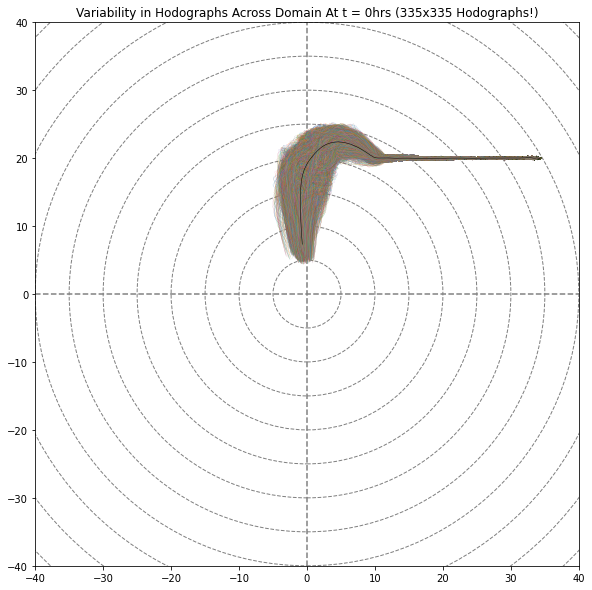

In [28]:
#Create A Swath of Hodographs Over the Entire Domain

gr_u_tot = storm16_data['uinterp'].loc[:,:, computations_data['y-direction'], computations_data['x-direction']]+offset_u
gr_v_tot = storm16_data['vinterp'].loc[:,:, computations_data['y-direction'], computations_data['x-direction']]+offset_v

#Create Hodographs
fig, ax = plt.subplots(figsize = (10,10))
h = metpy.plots.Hodograph(ax, component_range=40.)
h.add_grid(increment=5)

#Each Hodograph at Each Grid Point
for x in tqdm((np.arange(0,gr_u_tot.shape[3],1)), desc = 'Loading...'):
    for y in np.arange(0,gr_v_tot.shape[3],1):
        h.plot(gr_u_tot.loc[:,:,y,x][0],gr_v_tot.loc[:,:,y,x][0], linewidth = 0.1)

#Put The Domain Averaged Hodograph On Last
gr_u_avg = gr_u_tot[0].mean(axis = (1,2))
gr_v_avg = gr_v_tot[0].mean(axis = (1,2))
h.plot(gr_u_avg, gr_v_avg, color ='k', linewidth = 0.5)

plt.title(f"Variability in Hodographs Across Domain At t = 0hrs ({len(computations_data['x-direction'])}x{len(computations_data['y-direction'])} Hodographs!)")


# **Bunkers Storm Motion Variability**

In [97]:
#Define A Function That Computes Pressure-Weighted Mean Wind Over Specified Layer 

def mean_wind(top, bottom = None):
    #if bottom of layer isn't specified, assume that we start from the lowest level 
    if bottom is None:
        bottom = 0
        top = top
    
    #Using Pressure Data From Storm16 
    P = storm16_data['prs'][0].loc[:,computations_data['y-direction'],computations_data['x-direction']]
    
    #Start Relevant Counters at 0
    u_sum = 0.0
    v_sum = 0.0
    dp_sum = 0.0
    
    #Start Computations 
    for x in tqdm(np.arange(bottom,top,1)):
        if x == bottom:
            #initialize first data point 
            p_old = P[bottom].values
            u_old = gr_u_tot[bottom].values
            v_old = gr_v_tot[bottom].values
        else:
            #calculate dp and layer means 
            dp = p_old-P[x].values
            ulayermean = (gr_u_tot[x].values + u_old)/2
            vlayermean = (gr_v_tot[x].values + v_old)/2
            
            #update sums
            u_sum += dp*ulayermean
            v_sum += dp*vlayermean
            dp_sum += dp
            
            #update old values 
            p_old = P[x]
            u_old = gr_u_tot[x]
            v_old = gr_v_tot[x]
    
    #compute mean wind
    mean_u = u_sum/dp_sum
    mean_v = v_sum/dp_sum
    
    return mean_u.values,mean_v.values;
        
    




In [103]:
#Need To Compute Bunkers on My Own Because Metpy Runs Too Slow

#Global Variables Needed
P = storm16_data['prs'][0] #Pres in Pa
height = storm16_data['z'].values #Height in km

#original wind data
gr_u_tot = storm16_data['uinterp'].loc[:,:, computations_data['y-direction'], computations_data['x-direction']][0]+offset_u
gr_v_tot = storm16_data['vinterp'].loc[:,:, computations_data['y-direction'], computations_data['x-direction']][0]+offset_v

#Height Indexes of Interest
z_6km = (np.abs(height - 6)).argmin()
z_500m = (np.abs(height - .5)).argmin()
z_5500m = (np.abs(height - 5.5)).argmin()

#Step 1: compute mean wind over 500m, 6km, and 5500mto6km (first element in arrays are u-component, 2nd is v-component)
mean_6km = np.array(mean_wind(top = z_6km))
mean_500m = np.array(mean_wind(top = z_500m))
mean_5500m_2_6km = np.array(mean_wind(top = z_6km, bottom = z_5500m))

#Step 2: Compute Shear Vector, its cross product with the k vector, and compute shear vector magnitude
shear = mean_5500m_2_6km - mean_500m #Shear Vector

dtype = np.dtype([('u-component', float), ('v-component', float)])
shear_cross = np.empty((computations_data['y-direction'].shape[0],computations_data['x-direction'].shape[0]), dtype = dtype)
shear_cross['u-component'] = shear[1]
shear_cross['v-component'] = -shear[0]
shear_mag = np.hypot(shear[0], shear[1])

#Step 3: Compute Deviant Motion in Accordance with Bunkers (2000)
rdev_scalar = 7.5/shear_mag
rdev = np.empty((computations_data['y-direction'].shape[0],computations_data['x-direction'].shape[0]), dtype = dtype)
rdev['u-component'] = shear_cross['u-component']*rdev_scalar
rdev['v-component'] = shear_cross['v-component']*rdev_scalar

#Compute Storm Motion For Right Mover
right_mover = np.empty((computations_data['y-direction'].shape[0],computations_data['x-direction'].shape[0]), dtype = dtype)
right_mover['u-component'] = rdev['u-component']+mean_6km[0]
right_mover['v-component'] = rdev['v-component']+mean_6km[1]


100%|██████████| 3/3 [00:00<00:00, 114.79it/s]


Loading...: 100%|██████████| 335/335 [01:00<00:00,  5.58it/s]


Text(0, 0.5, 'v-component (m/s)')

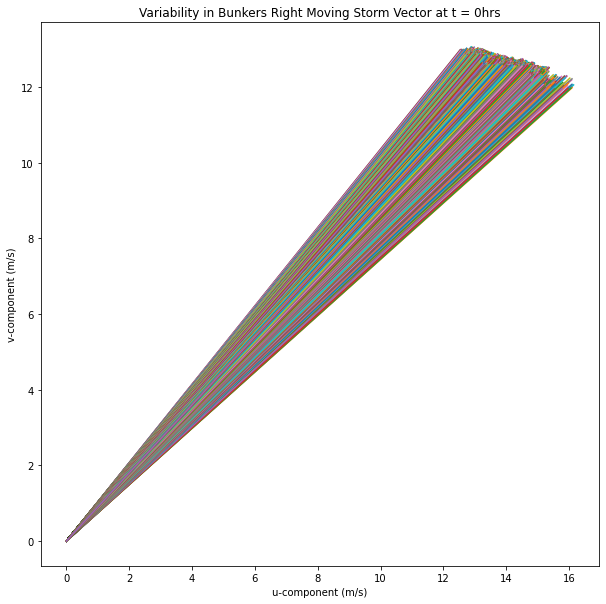

In [104]:
#Make Plot Of Bunkers Storm Motions 

#Create Hodographs
fig, ax = plt.subplots(figsize = (10,10))

for x in tqdm((np.arange(0,computations_data['x-direction'].shape[0],1)), desc = 'Loading...'):
    for y in np.arange(0,computations_data['y-direction'].shape[0],1):
        ax.plot([0,right_mover['u-component'][y][x]],[0,right_mover['v-component'][y][x]])
        
plt.title('Variability in Bunkers Right Moving Storm Vector at t = 0hrs')
plt.xlabel('u-component (m/s)')
plt.ylabel('v-component (m/s)')

Loading...: 100%|██████████| 335/335 [01:36<00:00,  3.46it/s]


Text(0, 0.5, 'v-component (m/s)')

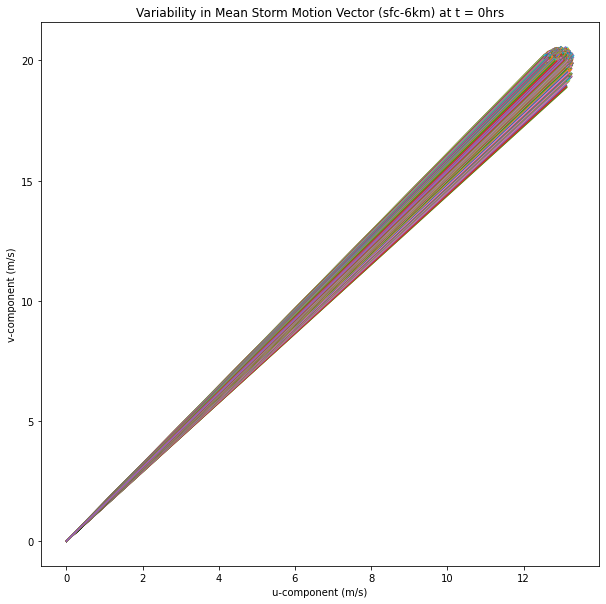

In [105]:
#Make Plot Of Mean Wind Vectors
#Create Hodographs
fig, ax = plt.subplots(figsize = (10,10))

for x in tqdm((np.arange(0,computations_data['x-direction'].shape[0],1)), desc = 'Loading...'):
    for y in np.arange(0,computations_data['y-direction'].shape[0],1):
        ax.plot([0,mean_6km[0][y][x]],[0,mean_6km[1][y][x]])
        
plt.title('Variability in Mean Storm Motion Vector (sfc-6km) at t = 0hrs')
plt.xlabel('u-component (m/s)')
plt.ylabel('v-component (m/s)')

Loading...: 100%|██████████| 335/335 [01:03<00:00,  5.32it/s]


Text(0, 0.5, 'v-component (m/s)')

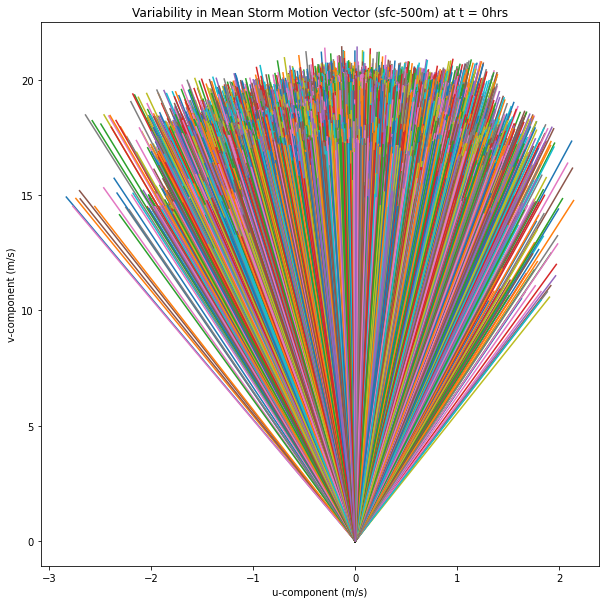

In [108]:
#Make Plot Of Mean Wind Vectors
#Create Hodographs
fig, ax = plt.subplots(figsize = (10,10))

for x in tqdm((np.arange(0,computations_data['x-direction'].shape[0],1)), desc = 'Loading...'):
    for y in np.arange(0,computations_data['y-direction'].shape[0],1):
        ax.plot([0,mean_500m[0][y][x]],[0,mean_500m[1][y][x]])
        
plt.title('Variability in Mean Storm Motion Vector (sfc-500m) at t = 0hrs')
plt.xlabel('u-component (m/s)')
plt.ylabel('v-component (m/s)')

Loading...: 100%|██████████| 335/335 [01:02<00:00,  5.35it/s]


Text(0, 0.5, 'v-component (m/s)')

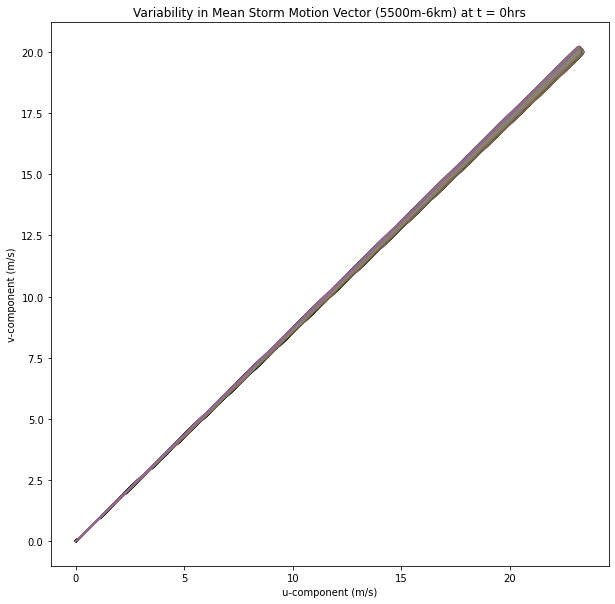

In [109]:
#Make Plot Of Mean Wind Vectors
#Create Hodographs
fig, ax = plt.subplots(figsize = (10,10))

for x in tqdm((np.arange(0,computations_data['x-direction'].shape[0],1)), desc = 'Loading...'):
    for y in np.arange(0,computations_data['y-direction'].shape[0],1):
        ax.plot([0,mean_5500m_2_6km[0][y][x]],[0,mean_5500m_2_6km[1][y][x]])
        
plt.title('Variability in Mean Storm Motion Vector (5500m-6km) at t = 0hrs')
plt.xlabel('u-component (m/s)')
plt.ylabel('v-component (m/s)')